In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# numpy for working with vector, matrices, etc. 
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick
from matplotlib import animation, cm

# for working with time and dates
import datetime

# scipy for stat and optimization 
from scipy import stats
from scipy import optimize

# Loading data using pandas datareader
from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

# numerical derivatives using statsmodels
from statsmodels.tools.numdiff import approx_fprime, approx_hess

# typehints
from typing import Union, List

# cvxopt and cvxpy for optimization 
import cvxopt 
import cvxpy as cp 


"""
Own packages
"""

# nominal yield curve data
from codelib.dal.fred_yield_data import get_nominal_yield_data

# moments: kurtosis with probs, etc. 
from codelib.statistics import moments as mom

# functions for calculating risk budget and portfolio risk metrics 
from codelib.portfolio_optimization import risk_budget as rb 
from codelib.portfolio_optimization import risk_metrics as rm

from codelib.visualization.base import correlation_plot, risk_waterfall_chart, waterfall_chart
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Exercises - Week 6

In this week we will look at a few exercises involving convex optimization and estimation. 

## Problem 1: Classical Mean-Variance optimization with constraints

An investor can invest in 10 different assets: Government bonds, Investment-grade bonds, High-yield bonds, Emerging markets gov. bonds, Equities (developed markets), Equities (Emerging markets), Private equity, Infrastructure, Real Estate, and Hedgefunds.  The continuously compounded / log-returns are assumed to be i.i.d. multivariate normally distributed

\begin{equation*}
	\mathbf{r}_{t + 1, 1} \sim MVN(\boldsymbol{\mu},\boldsymbol{\Sigma})
\end{equation*}

with correlation matrix

\begin{equation*}
	\mathbf{C} =   \begin{bmatrix}
		1.0 &  0.6 &  0.1 &  0.3 & -0.1 & -0.1 & -0.2 & -0.1 & -0.1 & -0.1 \\
		0.6 &  1.0 &  0.6 &  0.6 &  0.2 &  0.2 &  0.2 &  0.1 &  0.1 &  0.3 \\ 
		0.1 &  0.6 &  1.0 &  0.7 &  0.7 &  0.6 &  0.6 &  0.4 &  0.3 &  0.7 \\
		0.3 &  0.6 &  0.7 &  1.0 &  0.5 &  0.6 &  0.4 &  0.2 &  0.2 &  0.5 \\
		-0.1 &  0.2 &  0.7 &  0.5 &  1.0 &  0.7 &  0.8 &  0.4 &  0.4 &  0.8 \\
		-0.1 &  0.2 &  0.6 &  0.6 &  0.7 &  1.0 &  0.7 &  0.4 &  0.4 &  0.7 \\
		-0.2 &  0.2 &  0.6 &  0.4 &  0.8 &  0.7 &  1.0 &  0.4 &  0.4 &  0.7 \\
		-0.1 &  0.1 &  0.4 &  0.2 &  0.4 &  0.4 &  0.4 &  1.0 &  0.3 &  0.4 \\
		-0.1 &  0.1 &  0.3 &  0.2 &  0.4 &  0.4 &  0.4 &  0.3 &  1.0 &  0.4 \\
		-0.1 &  0.3 &  0.7 &  0.5 &  0.8 &  0.7 &  0.7 &  0.4 &  0.4 &  1.0
	\end{bmatrix},
\end{equation*}

vector of volatilities

\begin{equation*}
	\mathbf{v} =   \begin{bmatrix}
		0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094
	\end{bmatrix}^\top,
\end{equation*} 

and expected log return


\begin{equation*}
	\boldsymbol{\mu} =   \begin{bmatrix}
		0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038
	\end{bmatrix}^\top - \frac{1}{2} \text{Diag}(\boldsymbol{\Sigma}),
\end{equation*}

__Question 1__


Assume that $\mathbf{P}_0 = 1$. What is the distribution of the net portfolio return $\mathbf{w}^\top \mathbf{R}_1 = \mathbf{w}^\top \frac{\mathbf{P}_1}{\mathbf{P}_0} - 1$?  What is the expected portfolio return and standard deviation?


__Question 2__

Calculate the expected value and standard devation of an equally weighted portfolio. Calculate and visualize the risk contribution based on standard deviation as risk measure. 

__Question 3__

Define and solve the minimization problem using `cvxopt` or `cvxpy`

$$
\begin{align*}
	\min_{\mathbf{x}}  \quad & \mathbf{w}^\top  \text{Cov}[\mathbf{R}_1]  \mathbf{w} \\
	\textrm{s.t.} \quad 
     & \mathbf{1}^\top \mathbf{w} = 1\\
     & \text{E}[\mathbf{R}_1]^\top \mathbf{w} = \bar{\mu}\\
	 & \mathbf{w} \geq \mathbf{0}
\end{align*}
$$

Thus, minimize the portfolio variance subject to a given target return $\bar{\mu}$. Consider 50 different return targets from the lowest to the highest possible. 

Plot the optimal portfolio weights using a `matplotlib.pyplot.stackplot` for the return targets.  

__Question 4__

Using the optimal portfolios from above, plot the efficient frontier (plot the standard deviations against the expected return). Add the assets to the plot. 

__Question 5__

The optimal portfolios are dominated by a few assets. We want to impose a maximum allocation of $0.25$. Furthermore, we want to impose a maximum allocation of $0.4$ to alternatives: Private equity, Infrastructure, Real Estate, Hedgefunds. 

Repeat the last two questions, when imposing these constraints.


### Solution 

__Question 1__

We have assumed that the log-returns follow a multivariate normal distribution

$$
\mathbf{r}_{t+ 1, 1} = \log \frac{\mathbf{P}_{t+1}}{\mathbf{P}_t} \sim MVN(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Thus, the vector of asset prices at year one follows a multivariate log-normal distribution

$$
\log \mathbf{P}_1 \sim MVN(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \Leftrightarrow \mathbf{P}_1 \sim \log MVN(\boldsymbol{\mu}, \boldsymbol{\Sigma}) 
$$

The value of the portfolio in one year $\mathbf{w}^\top \mathbf{P}_1$ does not follow a log-normal since the weighted sum of log-normals does not follow a log-normal distribution! However, it is possible to derive the expected value and the variance


We need to find the expected value and covariance of the linear returns. We have 

$$
\text{E}[e^{\mathbf{r}_{1, 1}}] = \text{E}[\mathbf{P}_{1}] = e^{\mu  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma})}
$$

and 

$$
\text{Cov}[e^{\mathbf{r}_{1, 1}}] =  \text{Cov}[\mathbf{P}_{1}] =  \text{E}[e^{\mathbf{r}_{1, 1}}] \text{E}[e^{\mathbf{r}_{1,1}}]^\top \odot \left(e^{\boldsymbol{\Sigma}} - \mathbf{1} \right)
$$

The expected value and covariance of the linear returns are therefore

$$
\text{E}[\mathbf{R}_{1}] = \text{E}[\mathbf{P}_{1} - 1 ] = e^{\mu  + \frac{1}{2}\text{diag}(\boldsymbol{\Sigma})} - 1
$$

and 

$$
\text{Cov}[\mathbf{R}_{1}] =  \text{Cov}[\mathbf{P}_{1}] =  \text{E}[e^{\mathbf{r}_{1, 1}}] \text{E}[e^{\mathbf{r}_{1,1}}]^\top \odot \left(e^{\boldsymbol{\Sigma}} - \mathbf{1} \right)
$$


The portfolio return

$$
R_w = \mathbf{w}^\top \mathbf{R}_1
$$

has the expected value

$$
\text{E}[R_w] =  \mathbf{w}^\top \text{E}[\mathbf{R}_{1}]
$$

and variance

$$
\text{Var}[R_w] = \mathbf{w}^\top \text{Cov}[\mathbf{R}_{1}] \mathbf{w}
$$

__Question 2__

In [2]:
"""
Define inputs 
"""

asset_names = ["Government bonds", "Investment-grade bonds", "High-yield bonds",
               "Emerging markets gov. bonds", "Equities (developed markets)",
               "Equities (Emerging markets)", "Private equity", "Infrastructure",
               "Real Estate", "Hedgefunds"]

corr_mat = np.array([[1.00, 0.60, 0.10, 0.30, -0.10, -0.10, -0.20, -0.10, -0.10, -0.10],
                     [0.60, 1.00, 0.60, 0.60, 0.20, 0.20, 0.20, 0.10, 0.10, 0.30],
                     [0.10, 0.60, 1.00, 0.70, 0.70, 0.60, 0.60, 0.40, 0.30, 0.70],
                     [0.30, 0.60, 0.70, 1.00, 0.50, 0.60, 0.40, 0.20, 0.20, 0.50],
                     [-0.10, 0.20, 0.70, 0.50, 1.00, 0.70, 0.80, 0.40, 0.40, 0.80],
                     [-0.10, 0.20, 0.60, 0.60, 0.70, 1.00, 0.70, 0.40, 0.40, 0.70],
                     [-0.20, 0.20, 0.60, 0.40, 0.80, 0.70, 1.00, 0.40, 0.40, 0.70],
                     [-0.10, 0.10, 0.40, 0.20, 0.40, 0.40, 0.40, 1.00, 0.30, 0.40],
                     [-0.10, 0.10, 0.30, 0.20, 0.40, 0.40, 0.40, 0.30, 1.00, 0.40],
                     [-0.10, 0.30, 0.70, 0.50, 0.80, 0.70, 0.70, 0.40, 0.40, 1.00]])

vols = np.array([3.7, 5.5, 11.9, 10.7, 15.3, 21.7, 20.4, 14.0, 10.8, 9.4]) / 100.0

cov_mat = mom.corr_to_cov_matrix(corr_mat=corr_mat, vols=vols)

mu = np.array([1.9, 2.2, 4.9, 4.3, 6.1, 8.3, 10.2, 5.6, 4.1, 3.8]) / 100 - 0.5 * vols**2 

# number of assets 
num_assets = len(mu)

# equal portfolio weights 
eq_w = np.repeat(1.0 / num_assets, num_assets)

In [3]:
"""
Convert to mean and variance for linear returns
"""

mu_l = mom.calculate_log_norm_mean(mu, cov_mat) - 1.0
sigma_l = mom.calculate_log_norm_cov_mat(mu, cov_mat)

In [4]:
df_res = pd.DataFrame(columns=["Eq. weighted"], dtype=np.float64)
df_res.loc['$\mu_p$', :] = rm.calculate_portfolio_mean(weights=eq_w, mu=mu_l) * 100.0
df_res.loc['$\sigma_p$', :] = rm.calculate_portfolio_std(weights=eq_w, cov_mat=sigma_l) * 100.0

df_res.round(2)

,Eq. weighted
$\mu_p$,5.31
$\sigma_p$,9.68


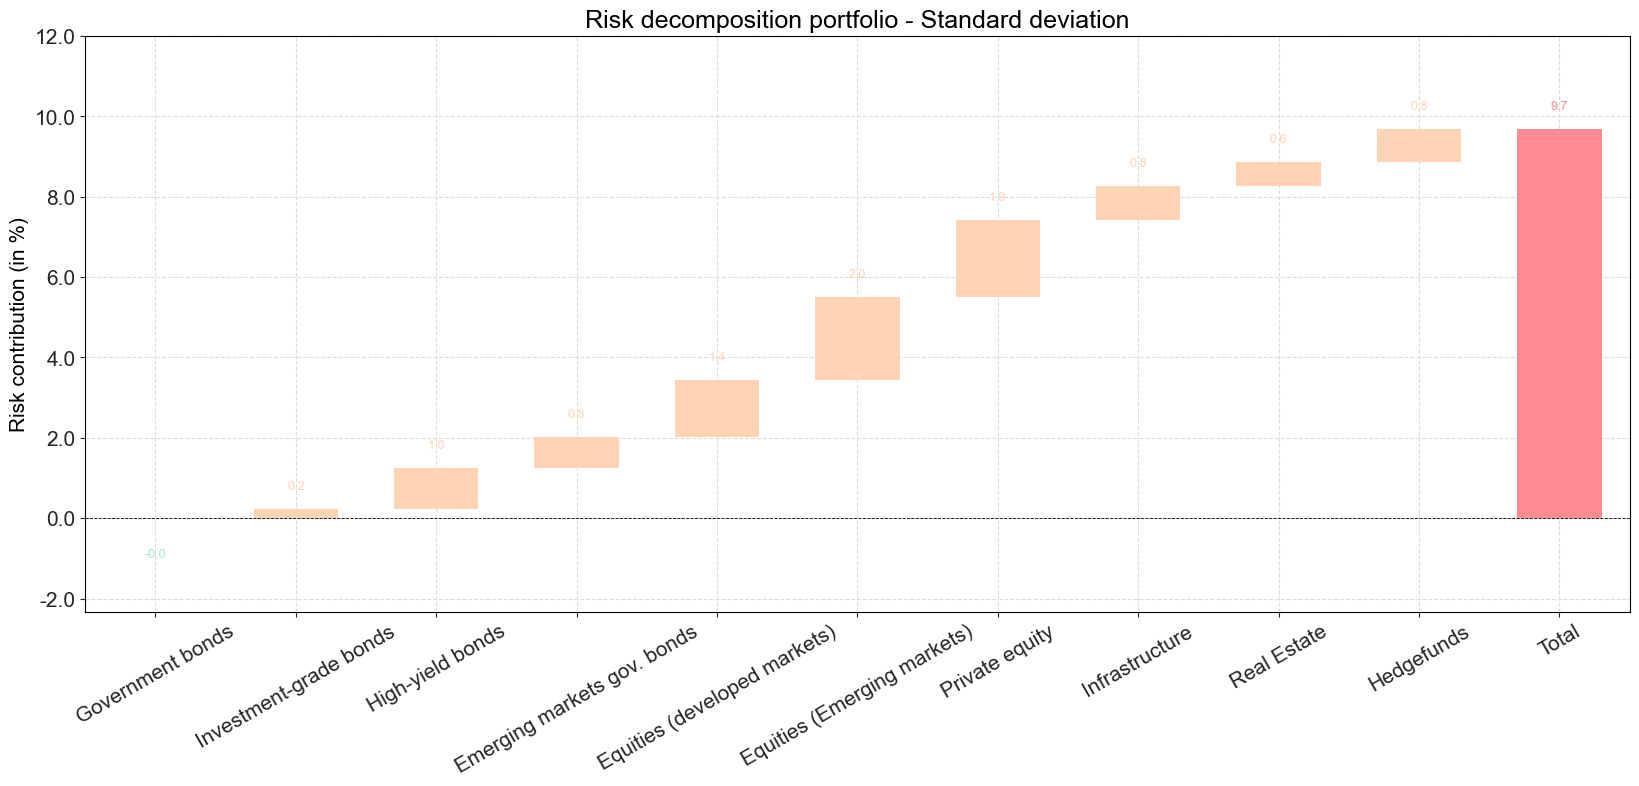

In [5]:
"""
Calculate risk contributions 
"""

std_contrib = rb.calculate_risk_contributions_std(weights=eq_w, cov_mat=sigma_l)

"""
Plot waterfall chart
"""

waterfall_chart(labels=asset_names, values=std_contrib*100)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decomposition portfolio - Standard deviation')
ax.set_ylabel('Risk contribution (in %)'); 

__Question 3__

In [6]:
"""
Define problem 
"""

# return targets to consider 
return_targets = np.linspace(np.min(mu_l), np.max(mu_l), 100)

# define cvxpy parameter 
mu_target = cp.Parameter()

# optimization variable 
w = cp.Variable(num_assets)

# define constraints 
constraints = [w >= 0]
constraints.append(cp.sum(w) == 1)
constraints.append(w @ mu_l == mu_target)

# define problem 
variance = cp.quad_form(w, sigma_l, assume_PSD=True)
prob =  cp.Problem(cp.Minimize(variance), constraints)

In [7]:
"""
Iterate over all possible return targets
"""

# define list for storing optimal portfolios 
optimal_portfolios = []

for mu in return_targets: 
    
    # set expected return target
    mu_target.value = mu
    
    # solve problem 
    prob.solve(verbose=False)
    
    # store optimal weights 
    optimal_portfolios.append(w.value)
    
# transform to numpy array 
optimal_portfolios = np.array(optimal_portfolios)

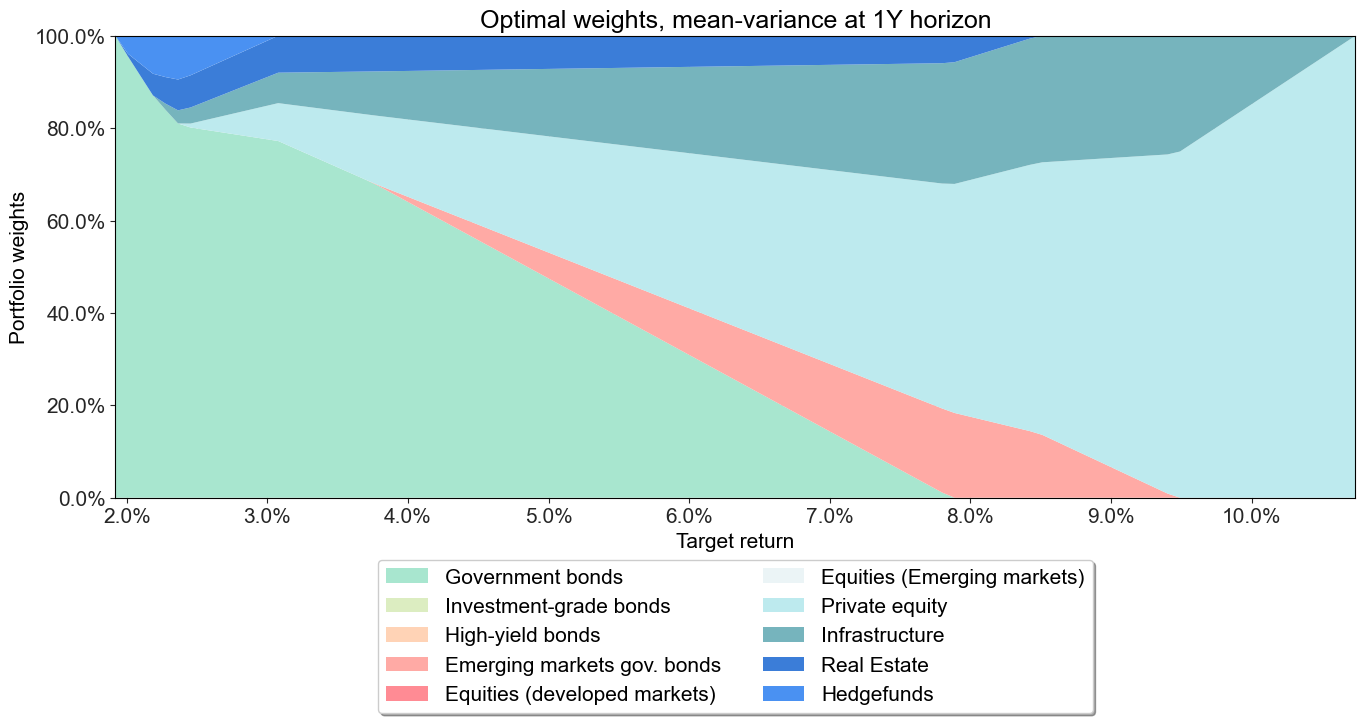

In [8]:
"""
Plot portfolio along the efficient frontier
"""

fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(return_targets, optimal_portfolios.T, labels=asset_names);
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 1Y horizon")
ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2);

__Question 4__

In [9]:
"""
Calculate port. expected return along efficient frontier
"""

eff_port_exp_return = np.apply_along_axis(rm.calculate_portfolio_mean,
                                          1, optimal_portfolios, mu_l)

"""
Calculate port. std
"""

eff_port_std = np.apply_along_axis(rm.calculate_portfolio_std,
                                   1, optimal_portfolios, sigma_l)

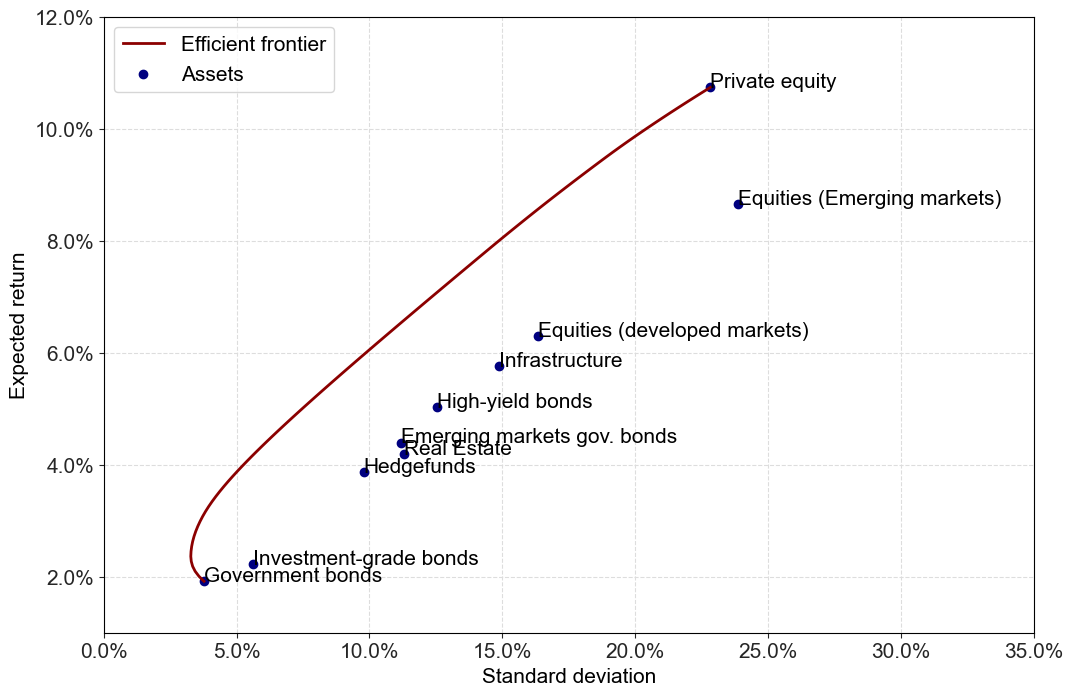

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

# plot efficient frontier 
ax.plot(eff_port_std, eff_port_exp_return, label="Efficient frontier",
        color="darkred")

# add the different assets 
assets_std = np.sqrt(np.diag(sigma_l))
ax.scatter(assets_std, mu_l, color="navy", label="Assets")
for i in range(num_assets):
    ax.annotate(asset_names[i], (assets_std[i], mu_l[i]))

# set correct tick labels, etc. 
ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)

ax.set(xlabel="Standard deviation", ylabel="Expected return")

ax.set_xlim([0.0, 0.35])
ax.set_ylim([0.01, 0.12])
ax.legend(loc="upper left");

__Question 5__

In [11]:
"""
Define problem 
"""

# return targets to consider 
return_targets = np.linspace(np.min(mu_l) + 0.015, np.max(mu_l) - 0.03, 100)

# define cvxpy parameter 
mu_target = cp.Parameter()

# optimization variable 
w = cp.Variable(num_assets)

# define constraints 
constraints = [w >= 0]
constraints.append(cp.sum(w) == 1)
constraints.append(w @ mu_l == mu_target)
constraints.append(w<=0.25)
constraints.append(np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1]) @ w <= 0.4)

# define problem 
variance = cp.quad_form(w, sigma_l, assume_PSD=True)
prob =  cp.Problem(cp.Minimize(variance), constraints)

In [12]:
"""
Iterate over all possible return targets
"""

# define list for storing optimal portfolios 
optimal_portfolios_w_max_alloc = []

for mu in return_targets: 
    
    # set expected return target
    mu_target.value = mu
    
    # solve problem 
    prob.solve(verbose=True)
    
    # store optimal weights 
    optimal_portfolios_w_max_alloc.append(w.value)
    
# transform to numpy array 
optimal_portfolios_w_max_alloc = np.array(optimal_portfolios_w_max_alloc)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 06 07:03:22 PM: Your problem has 10 variables, 23 constraints, and 1 parameters.
(CVXPY) Oct 06 07:03:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 06 07:03:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 06 07:03:22 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 06 07:03:22 PM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 06 07:03:22 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Oct 06 07:03:22 PM: Ap

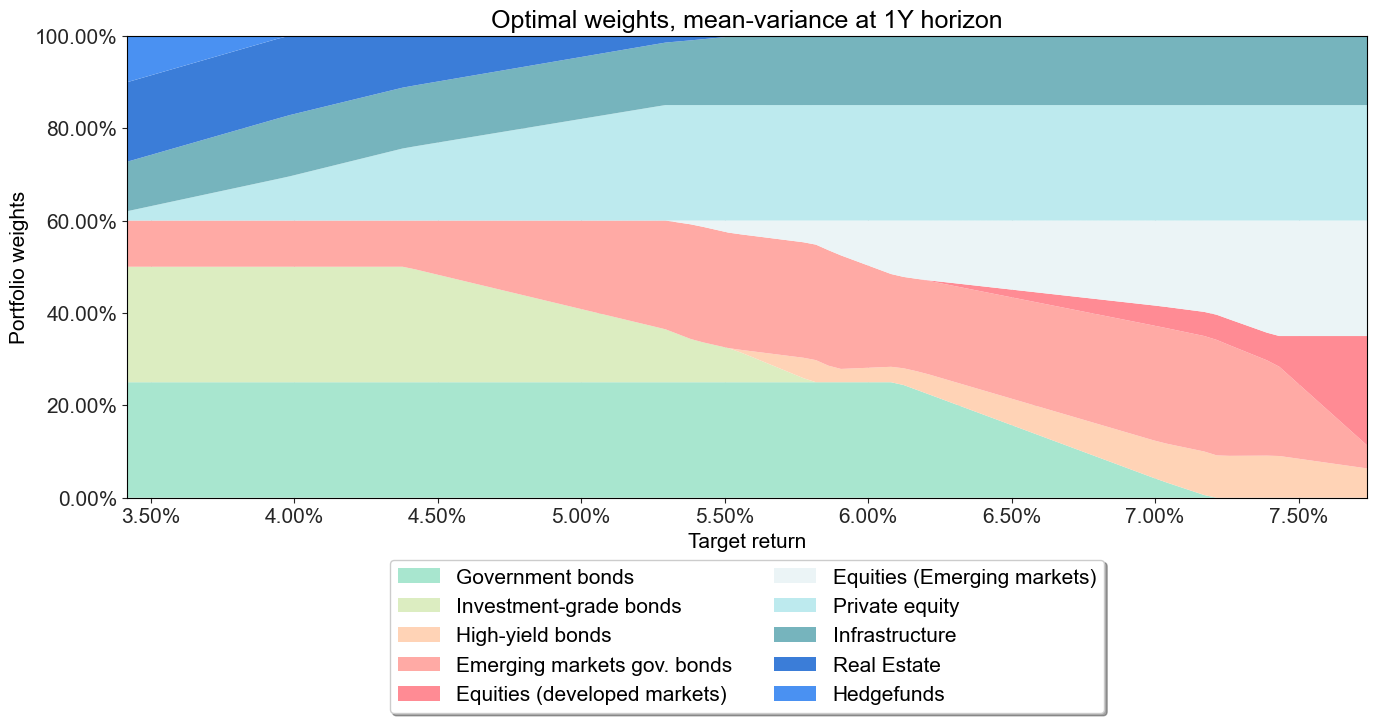

In [13]:
"""
Plot portfolio along the efficient frontier
"""

fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(return_targets, optimal_portfolios_w_max_alloc.T,
             labels=asset_names);
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 1Y horizon")
ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2);

In [14]:
"""
Calculate port. expected return along efficient frontier
"""

eff_port_exp_return_w_max_alloc= np.apply_along_axis(rm.calculate_portfolio_mean,
                                          1, optimal_portfolios_w_max_alloc, mu_l)

"""
Calculate port. std
"""

eff_port_std_w_max_alloc = np.apply_along_axis(rm.calculate_portfolio_std,
                                   1, optimal_portfolios_w_max_alloc, sigma_l)

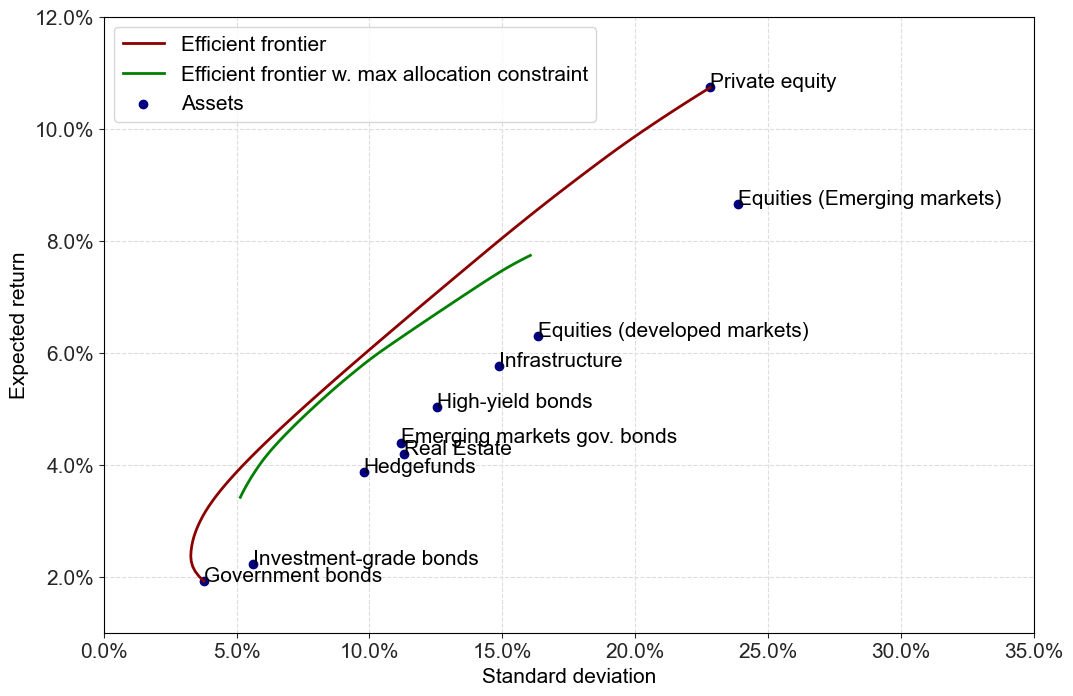

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

# plot efficient frontier 
ax.plot(eff_port_std, eff_port_exp_return, label="Efficient frontier",
        color="darkred")

ax.plot(eff_port_std_w_max_alloc, eff_port_exp_return_w_max_alloc,
        label="Efficient frontier w. max allocation constraint",
        color="green")

# add the different assets 
assets_std = np.sqrt(np.diag(sigma_l))
ax.scatter(assets_std, mu_l, color="navy", label="Assets")
for i in range(num_assets):
    ax.annotate(asset_names[i], (assets_std[i], mu_l[i]))

# set correct tick labels, etc. 
ticks = mtick.PercentFormatter(1)
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)

ax.set(xlabel="Standard deviation", ylabel="Expected return")

ax.set_xlim([0.0, 0.35])
ax.set_ylim([0.01, 0.12])
ax.legend(loc="upper left");

## Problem 2: Hedging a cash flow

__Question 1__

Download the US Treasury nominal zero coupon yields using e.g. `dal.fred_yield_data.get_nominal_yield_data`. 

Visualize the data using a scatter plot for 1st September 2023.  

__Question 2__

For simplicity, assume that we have 8 bullet bonds available with respectively 1, 3, 5, 7, 10, 13, 15, 20 years to maturity. All have bonds have a coupon of 4\% with annual payments and face value of 100 (e.g the 3 year bond has a payment of 4 one and two year from now, and a payment of 104 three years from now). 

Calculate the present value (price) of the bonds cash flow.  

__Question 3__

Create a cash flow matrix (number of bonds x number of cash flow time ponts) using all the bonds such that the rows contains the cash flows for each bond. 

__Question 4__

Asssume a liability cash flow of 


|  Time  |            Cash flow |
|---:|-------------:|
|  1 | 1000000   |
|  2 | 1100000 |
|  3 | 1200000 |
|  4 | 1300000 |
|  5 | 1400000 |
|  6 | 1500000 |
|  7 | 1400000 |
|  8 | 1300000 |
|  9 | 1200000 |
| 10 | 1100000 |
| 11 | 1000000  |
| 12 | 900000       |
| 13 | 800000       |
| 14 | 700000       |
| 15 | 600000       |
| 16 | 500000       |
| 17 | 400000       |
| 18 | 300000       |
| 19 | 200000       |
| 20 | 100000       |

Plot the liability cash flow with a bar plot. 

__Question 5__

It is possible to solve the simple cash flow matching problem using linear programming [[W]](https://en.wikipedia.org/wiki/Cashflow_matching). Suppose that we have a choice of $j=1,...,n $ bonds with which to receive cash flows over $t=1,...,T$ time periods in order to cover liabilities $L_{1},...,L_{T}$ for each time period.  The $j$th bond in time period $t$ is assumed to have known cash flows $C_{jt}$ and initial price $p_{j}$. It possible to buy $x_{j}$ bonds and to run a surplus $s_{t}$ in a given time period, both of which must be non-negative, and leads to the set of constraints

$$\begin{align}
\sum_{j=1}^{n}C_{j1}x_{j} - s_{1} &= L_{1} \\
\sum_{j=1}^{n}C_{jt}x_{j} + s_{t-1} - s_{t} &= L_{t}, \quad t = 2,...,T
\end{align}
$$

Our goal is to minimize the initial cost of purchasing bonds to meet the liabilities in each time period, given by $\mathbf{p}^{\top} \mathbf{x}$. Together, these requirements give rise to the associated linear programming problem

$$
\min \mathbf{p}^\top \mathbf{x}
$$

subject to the constraints

$$
\mathbf{C}^\top \mathbf{x} + \mathbf{R} \mathbf{s} \geq \mathbf{L}
$$

and 

$$
\mathbf{x}, \mathbf{s} \geq 0
$$

where $\mathbf{C}$ is the $n \times T$ matrix and $\mathbf{R}$ is a $T \times T$ matrix with $R_{t,t}=-1$ and $R_{t+1, t}=1$

Define and solve the cash flow matching problem using either `cvxopt` or `cvxpy`. 

__Question 6__

Compare the cummulative liability cash flow with the cummulative hedge cash flow using a bar plot. 

### Solution 

__Question 1__


In [16]:
# Get zero yields
df_zero_yields = get_nominal_yield_data(output_type="zero_yields")
zero_yields = df_zero_yields.loc['2023-09-01', :].values

# define tenors / time to maturity
tenors = np.array([float(text[-2:])  for text in df_zero_yields.columns])

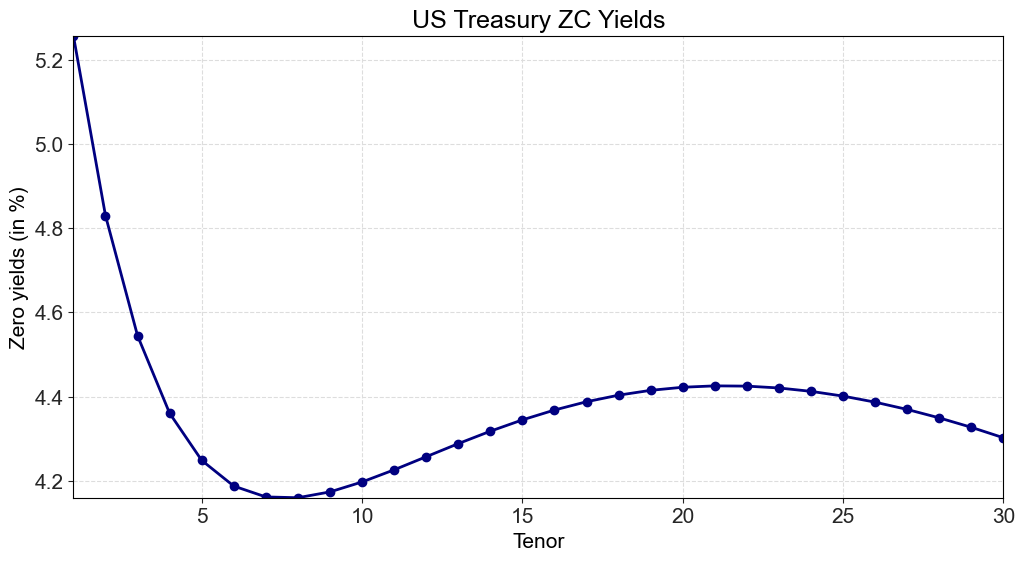

In [17]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(tenors, zero_yields, color="navy", linestyle="-", marker="o")
ax.set(xlabel="Tenor", ylabel="Zero yields (in %)", title="US Treasury ZC Yields");

__Question 2__

In [18]:
from scipy.interpolate import splev, splrep
from functools import reduce

# define zero coupon curve - divid by 100 to get yields to decimal number
zero_curve_spline = splrep(tenors, zero_yields / 100)

In [19]:
"""
One possibility would also just be to type the cash flow matrix manually...
"""

coupon = 0.04

# define maturities
maturities = np.array([1, 3, 5, 7, 10, 13, 15, 20])

# prices 
prices = list()
# cash flow time points
term_info = list()
# cash flows 
flow_info = list()

# loop over all maturities 
for maturity in maturities: 
    
    # create cash flow time points
    terms = np.arange(1.0, maturity + 1.0, 1.0)
    # create cash flow
    flows = np.ones_like(terms) * 100 * 0.04 
    flows[-1] += 100
    
    # store info
    term_info.append(terms)
    flow_info.append(flows)
    
    # calculate price
    prices.append(np.sum(flows * np.exp(-terms * splev(terms, zero_curve_spline))))

In [20]:
df_res = pd.DataFrame(index=maturities, data=prices, columns=["Price"])
df_res.index.name="Maturity"
df_res

,Price
Maturity,
1,98.674139
3,98.171800
5,98.372969
7,98.339424
10,97.578845
13,96.325060
15,95.445748
20,93.701847


__Question 3__

In [21]:
# Get union of all cash flow time points 
all_terms = reduce(np.union1d, term_info)

# define the shape of the cash flow matrix 
cash_flow_matrix = np.zeros((maturities.shape[0] , all_terms.shape[0]))

# create the cash flow matrix 
idx = 0
for terms, flows in zip(term_info, flow_info):
    
    indicator = np.in1d(all_terms, terms)
    cash_flow_matrix[idx, indicator] = flows
    
    idx += 1

In [22]:
pd.DataFrame(index=maturities, data=cash_flow_matrix, columns=all_terms)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
1,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,4.0,4.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,4.0,4.0,4.0,4.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,104.0,0.0,0.0,0.0,0.0,0.0
20,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,104.0


__Question 4__

In [23]:
liab_time_points = np.arange(1.0, 21.0, 1.0)
liab_cash_flows = np.array([1.0, 1.1, 1.2, 1.3, 1.4, 1.5,
                            1.4, 1.3, 1.2, 1.1, 1.0, 0.9,
                            0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 
                            0.2, 0.1]) * 1e6

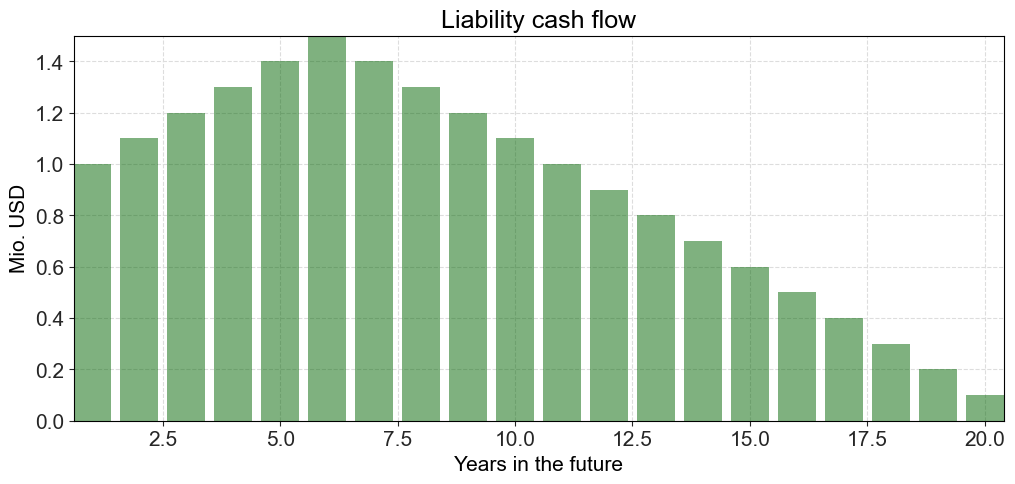

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(liab_time_points, liab_cash_flows / 1e6, color="darkgreen", alpha=0.5); 

ax.set_title("Liability cash flow")
ax.set_xlabel("Years in the future")
ax.set_ylabel("Mio. USD");

__Question 5__

In [25]:
num_time_points = len(liab_time_points)
num_bonds = len(maturities)

r_mat  = -np.eye(num_time_points)
r_mat[range(num_time_points - 1), range(1, num_time_points)] =  1

In [26]:
x = cp.Variable(num_bonds)
s = cp.Variable(num_time_points)

c_mat = cash_flow_matrix
b_vec = liab_cash_flows
p_vec = np.array(prices)

problem = cp.Problem(cp.Minimize(p_vec @ x),
                     [c_mat.T @ x + r_mat.T @ s >= b_vec, x >= 0, s >= 0])

problem.solve()

x.value

array([10545.75596713, 15591.23558686, 21057.17187069, 30814.33493569,
       25050.9873511 , 12884.04641023, 19045.85800148,   961.53837057])

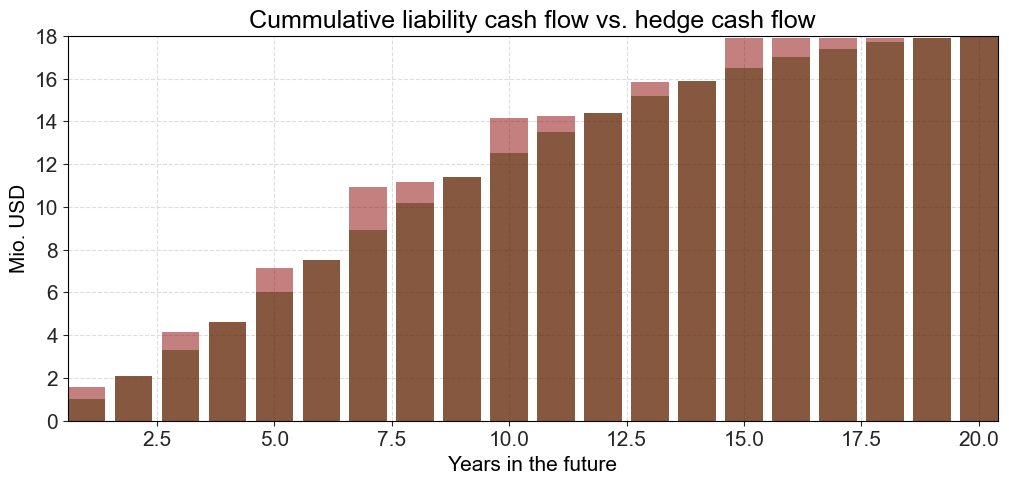

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(liab_time_points, liab_cash_flows.cumsum() / 1e6, color="darkgreen", alpha=0.5); 
ax.bar(liab_time_points, (c_mat.T @ x.value).cumsum() / 1e6, color="darkred", alpha=0.5); 

ax.set_title("Cummulative liability cash flow vs. hedge cash flow")
ax.set_xlabel("Years in the future")
ax.set_ylabel("Mio. USD");

## Problem 3: OLS vs. MLE

Consider the regression model

$$
y_i = \alpha + \beta_1 x_{1, i} + \beta_{2, i} x_{2, i} + \varepsilon_i =  \mathbf{x}_i^\top \boldsymbol{\beta} + \varepsilon_i
$$

where $\alpha=1$, $\beta_1 = 1$, and $\beta_2 = 1$. Furthermore, assume that $x_{1, i} \sim  \log N(0, 1)$, $x_{2, i} \sim \log N(0, 1)$ and $\varepsilon_{i} + \xi + \omega \frac{\alpha}{\sqrt{1 + \alpha^2}} \sqrt{2 / \pi} \sim skew normal(\xi, \omega, \alpha)$ with $\xi=0$, $\omega=2$, $\alpha=2$ (we add the mean to make the error term have a mean of zero). The [skew normal](https://en.wikipedia.org/wiki/Skew_normal_distribution) is defined by the density 

$$
f(\varepsilon) = \frac{2}{\omega} \phi(\frac{\varepsilon - \xi}{\omega})\Phi(\alpha\frac{\varepsilon - \xi}{\omega})
$$

__Question 1__

Simulate and estimate the model with OLS 10,000 times for different sample sizes. Plot the kernel density of the estimates. What do you observe, when the sample size increases?

__Question 2__

Simulate and estimate the model with MLE 10,000 times for different sample sizes. Restrict $\xi=0$. Plot the kernel density of the estimates. What do you observe, when the sample size increases?


__Question 3__

Compare the density of the OLS and MLE estimates. Also calculate the standard devation of the OLS estimates. What do you observe? Is this inline with your expectation. 


### Solution 

__Question 1__

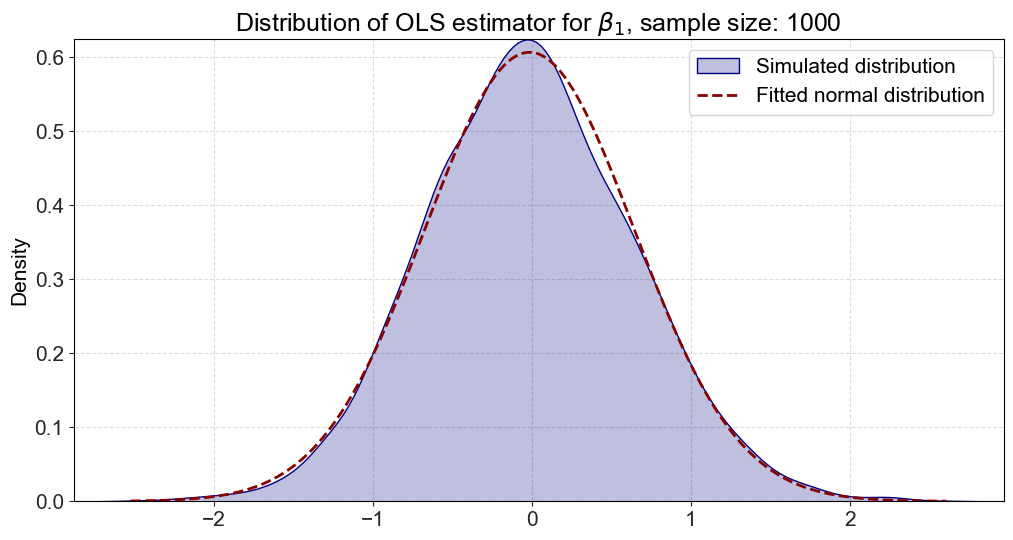

In [ ]:
"""
Settings
"""

# number of simulations
num_sim = 4999

# sample size 
sample_size = 1000

# true parameter values: constant, beta1, beta2
beta0 = np.array([1.0, 1.0, 1.0])

alpha = 2.0
omega = 2.0
xi = 0.0

"""
Simulations
"""

all_beta_est = np.empty((num_sim, len(beta0)))
for i in range(num_sim): 
    
    # generate independent variables
    x1_sim = stats.lognorm.rvs(1, scale=1, size=sample_size) 
    x2_sim = stats.lognorm.rvs(1, scale=1, size=sample_size)
    x_mat_sim = np.vstack([np.ones(sample_size), x1_sim, x2_sim]).T

    # simulate error term
    eps_sim = stats.skewnorm.rvs(alpha, loc=-omega*alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi),
                                 scale=omega, size=sample_size)

    # simulate dependent variable
    y_sim = x_mat_sim @ beta0 + eps_sim
    
    # estimate parameters
    beta_est, res, _, _ = np.linalg.lstsq(x_mat_sim, y_sim, rcond=-1)
    
    all_beta_est[i, :] = beta_est

"""
Plotting
"""
    
idx = 1 # 0: constant, 1: beta1, 2: beta2
param_name_dict = {0: '$\\alpha$', 1: '$\\beta_1$', 2: '$\\beta_2$'}
diff = (all_beta_est[:, idx] - beta0[idx]) * np.sqrt(sample_size)

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(diff, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution")

norm_params = stats.norm.fit(diff)

vals_to_eval = np.linspace(min(diff), max(diff), 1000)
ax.plot(vals_to_eval, stats.norm(norm_params[0], norm_params[1]).pdf(vals_to_eval), color="darkred", linestyle="--",
        label="Fitted normal distribution")

ax.set(title="Distribution of OLS estimator for " + param_name_dict[idx] + ", sample size: {}".format(sample_size))

ax.legend();

__Question 2__



In [ ]:
"""
Define log-likelihood function
"""

def log_like_lin_reg(params, y, x, individual=False):
    
    beta = params[:3]
    alpha = params[3]
    omega = params[4]
    
    loc = -omega * alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi)
    
    eps = y - x @ beta
    
    log_like = stats.skewnorm.logpdf(eps, a=alpha, scale=omega, loc=loc)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

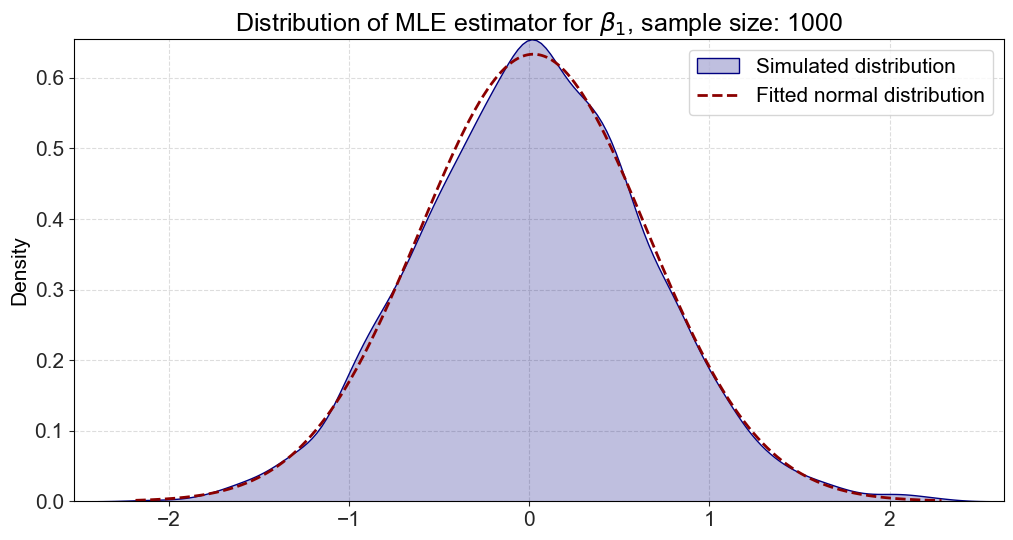

In [30]:
"""
Settings
"""

# number of simulations
num_sim = 4999

# sample size 
sample_size = 1000

# true parameter values: constant, beta1, beta2
beta0 = np.array([1.0, 1.0, 1.0])

"""
Simulations
"""

all_beta_est_mle = np.empty((num_sim, len(beta0) + 2))
for i in range(num_sim): 
    
    # generate independent variables
    x1_sim = stats.lognorm.rvs(1, scale=1, size=sample_size) 
    x2_sim = stats.lognorm.rvs(1, scale=1, size=sample_size)
    x_mat_sim = np.vstack([np.ones(sample_size), x1_sim, x2_sim]).T

    # simulate error term
    eps_sim = stats.skewnorm.rvs(alpha, loc=-omega*alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi),
                                 scale=omega, size=sample_size)

    # simulate dependent variable
    y_sim = x_mat_sim @ beta0 + eps_sim
    
    # estimate parameters
    res = optimize.minimize(log_like_lin_reg, [1.0, 1.0, 1.0, 1.5, 1.5],
                            args=(y_sim, x_mat_sim),
                            bounds=((-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf),
                                    (0.5, np.inf), (0.5, np.inf))) # add some reasonable constraints
    
    # store parameter estimates
    all_beta_est_mle[i, :] = res.x

"""
Plotting
"""
    
idx = 1 # 0: constant, 1: beta1, 2: beta2
param_name_dict = {0: '$\\alpha$', 1: '$\\beta_1$', 2: '$\\beta_2$'}
diff = (all_beta_est_mle[:, idx] - beta0[idx]) * np.sqrt(sample_size)

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(diff, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution")

norm_params = stats.norm.fit(diff)

vals_to_eval = np.linspace(min(diff), max(diff), 1000)
ax.plot(vals_to_eval, stats.norm(norm_params[0], norm_params[1]).pdf(vals_to_eval), color="darkred", linestyle="--",
        label="Fitted normal distribution")

ax.set(title="Distribution of MLE estimator for " + param_name_dict[idx] + ", sample size: {}".format(sample_size))

ax.legend();

__Question 3__

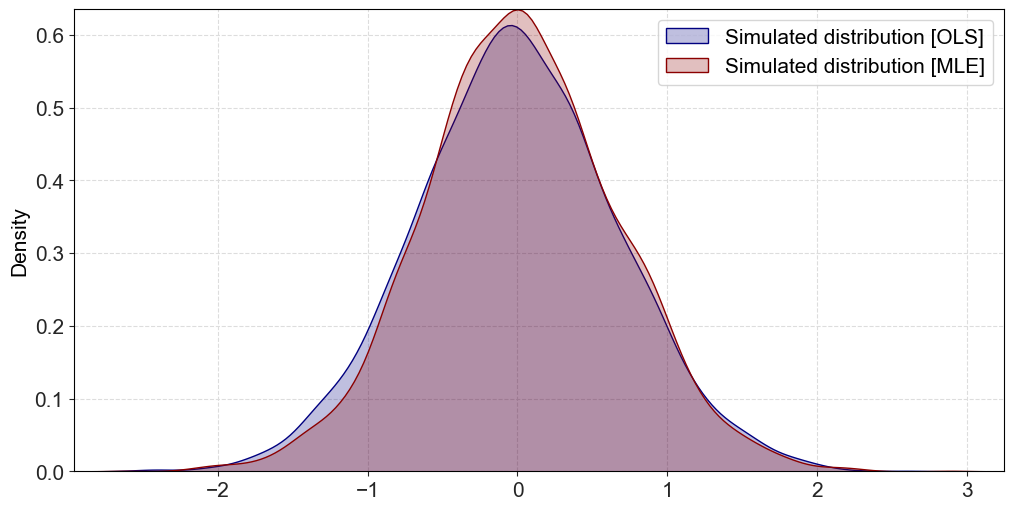

In [31]:
idx = 2

fig, ax = plt.subplots(figsize=(12, 6))
diff_ols = (all_beta_est[:, idx] - beta0[idx]) * np.sqrt(sample_size)
sns.kdeplot(diff_ols, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution [OLS]")

diff_mle = (all_beta_est_mle[:, idx] - beta0[idx]) * np.sqrt(sample_size)
sns.kdeplot(diff_mle, color="darkred", ax=ax, fill=True, alpha=0.25, label="Simulated distribution [MLE]")

ax.legend();

In [32]:
diff_mle.std()

0.6475683410267333

In [33]:
diff_ols.std()

0.6736128156186535

The MLE should be more efficient than the OLS - so this is inline with our expectation!

## Problem 4: Recession forecasting [optional]

__Note:__ We follow the exposition of [Nyberg (2010)](https://onlinelibrary-wiley-com.esc-web.lib.cbs.dk:8443/doi/abs/10.1002/for.1161)

In this exercise, we will explore a simple model for forecasting US recessions. Among other things, we will look at the evidence for the yield spread being a predictor of recessions as often mentioned in financial news (and the academic literature). 

We are interested in prediciting the recession indicator $y_t, \; t=1,..., T$ which is a binary dependent variable that is defined by

$$
y_t = \left\{ \begin{matrix}
                1, & \text{if the economy is in a recessionary state at time } t \\ 
                0, & \text{if the economy is in a expansionary state at time } t
              \end{matrix}  \right.
$$

The probability of the dependent variable taking the value $1$ is given by $p_t$ specified as 

$$
p_t = \text{Prob}_{t-1}[y_t = 1] = \Phi(\pi_{t})
$$

where $\Phi()$ is the cdf of a standard normal. $\pi_{t}$ is included in the information set at time $t-1$. This model is known as a [Probit model](https://en.wikipedia.org/wiki/Probit_model). 

A model not taking the dynamic structure into account is given by the static formulation ($k \leq 1$ must be larger than the forecast horizon) 

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta
$$

A dynamic structure can be implemented as ($l \leq 1$)

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

A dynamic autoregressive model can be implemented as 

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l} + \alpha \pi_{t-1}
$$

__Question 1__

Get recession indicators ('USREC') and yield spread ('T10YFF') from the FRED database from the beginning of 1983. Plot the yield spread together with the recession indicators. 

__Question 2__

First, we will consider a model where we solely use the yield spread (and a constant) to predict recessions. To that end, we need to define the likelihood function. 

The conditional probability function is given by

$$
f_{Y_t}(y_t \vert \mathbf{x}_t, \mathbf{x}_{t-1},..., y_{t-1},...; \theta)   = p_t^{y_t} (1 - p_t)^{1 - y_t} = \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$

We can therefore write the (conditional) likelihood function as 

$$
L_T(\theta) = \prod_{t=1}^T \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$


and the log-likelihood function as 

$$
\mathcal{L}_{T}(\theta) = \sum_{t=1}^T q_t(y_t, \mathbf{x}_t; \theta) = \sum_{t=1}^T \left[y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))  \right]
$$

Assume that $\pi_{t} = \mathbf{x}_{t-k}^\top \beta$ with $\mathbf{x}_{t-k} = [1, ys_{t-k}]^\top$ where $ys_{t}$ is the yield-spread at time $t$. Consider $k=6$. Estimate the model using maximum-likelihood. 


__Question 3__

Derive the expressions for

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n  \frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top}  \\
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  
\end{align}
$$
when considering the static model. It may be usefull to remember that 

$$
\frac{\partial \Phi(\pi_t)}{\partial \theta} = \phi(\pi_t) \frac{\partial \pi_t}{\partial \theta}  = \phi(\pi_t) \mathbf{x}_{t-k}
$$

where $\phi(\pi_t)$ is the density of a standard normal and 

$$
\frac{\partial \phi(\pi_t)}{\partial \theta} = -\phi(\pi_t) \pi_t \frac{\partial \pi_t}{\partial \theta}
$$

Implement functions that calculate these quantities. 

__Question 4__

Calculate the standard errors analytically and numerically. 

__Quesiton 5__

Check the results using `statsmodels`. Are the parameters significant at a 5\% significance level?

__Question 6__

Implement and estimate the dynamic model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

__Question 7__

Implement and estimate the autoregressive model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta  + \alpha \pi_{t-1}
$$

__Note:__ We have only considered in-sample results which may not work out-of-sample. 

### Solution

__Question 1__


In [34]:
df_data = DataReader(['USREC', 'T10YFF', 'T10Y3M'], 'fred', start=datetime.date(1983,1,1))

In [35]:
df_data

,USREC,T10YFF,T10Y3M
DATE,,,
1983-01-01,0.0,NaN,NaN
1983-01-03,NaN,1.13,2.15
1983-01-04,NaN,0.90,2.09
1983-01-05,NaN,1.89,2.10
1983-01-06,NaN,1.91,2.19
...,...,...,...
2024-09-30,NaN,-1.02,-0.92
2024-10-01,NaN,-1.09,-0.97
2024-10-02,NaN,-1.04,-0.90


In [36]:
df_data_monthly = df_data.resample('M').first().dropna()
df_data_monthly.index = df_data['USREC'].dropna().index

C:\Users\johan\AppData\Local\Temp\ipykernel_12652\4182445354.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_data_monthly = df_data.resample('M').first().dropna()


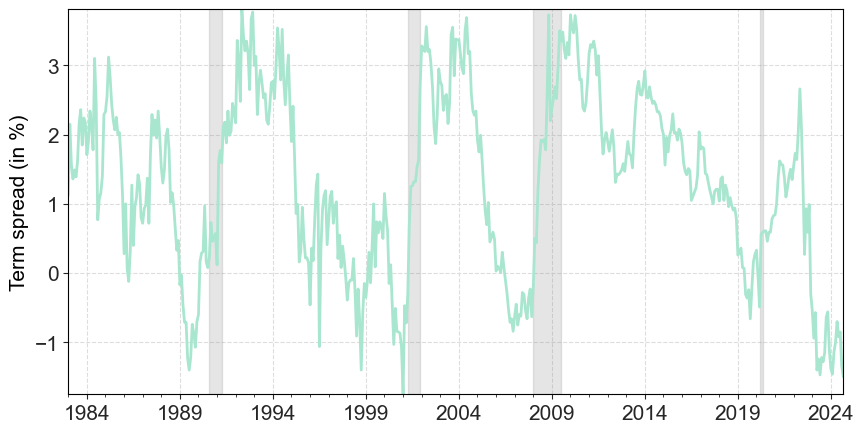

In [37]:
nber_recessions = df_data_monthly['USREC'].dropna()

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax = df_data_monthly['T10YFF'].plot(figsize=(10,5));
ax.set_ylabel('Term spread (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

__Question 2__

First, we implement the log-likelihood function 

In [38]:
"""
Log-likelihood function 
"""

def log_like_probit(beta, y, x, individual=False): 
    
    pi = x @ beta
    prob = stats.norm.cdf(pi)
    
    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

Next, we select the data which we want to use

In [39]:
k = 6
y_data = df_data_monthly['USREC'].values[k:]
x_data = df_data_monthly['T10YFF'].values[:-k] / 100
x_data = np.c_[np.ones_like(x_data), x_data]

In [40]:
"""
Minimize negative log-likelihood 
"""
res = optimize.minimize(log_like_probit, [0.13,0.0], args=(y_data, x_data))
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 117.93688368183902
        x: [-1.145e+00 -3.238e+01]
      nit: 14
      jac: [-9.537e-07 -1.907e-06]
 hess_inv: [[ 1.063e-02 -3.751e-01]
            [-3.751e-01  5.177e+01]]
     nfev: 45
     njev: 15

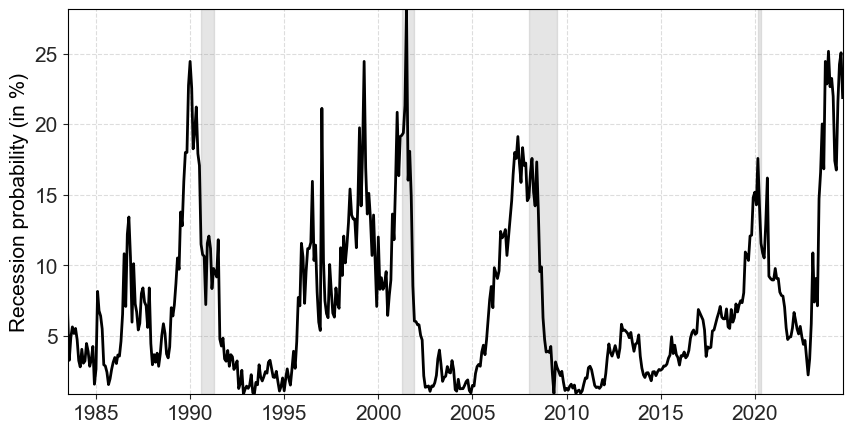

In [41]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_data @ res.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)
    

__Question 3__

We note that 

$$
q_t(y_t, \mathbf{x}_t; \theta) = y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))
$$

First, we find the gradient (using the chain-rule, derivative of natural logarithm, fundamental theorem of calculus, etc.)

$$
\begin{align}
\frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta} &= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial \Phi(\pi_{t})}{\partial \theta}\\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\frac{\partial \pi_{t}}{\partial \theta} \\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t
\end{align}
$$

Implying that 

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  = \frac{1}{n} \sum_{i=1}^n \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]^2 \phi(\pi_{t})^2\mathbf{x}_t\mathbf{x}_t^\top
\end{align}
$$

The Hessian is given by 

$$
\begin{align}
\frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top} &= \frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \\
&= \left[\frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \right] + \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial}{\partial \theta}\phi(\pi_{t})\mathbf{x}_t^\top \\
&=\left[-y_t \frac{1}{\Phi(\pi_{t})^2} - (1-y_t) \frac{1}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\phi(\pi_{t})\mathbf{x}_t^\top - \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]  \phi(\pi_{t}) \mathbf{x}_t^\top \beta \mathbf{x}_t \mathbf{x}_t^\top \\
&=-\left[y_t \frac{\phi(\pi_{t}) + \mathbf{x}_t^\top \beta \Phi(\pi_{t})}{\Phi(\pi_{t})^2} + (1-y_t) \frac{\phi(\pi_{t}) - (1 -\Phi(\pi_{t}))\mathbf{x}_t^\top \beta}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\mathbf{x}_t^\top 
\end{align}
$$

Below, we implement the expressions. 

In [42]:
"""
Gradient (outer product of the scores)
"""

def outer_gradient(theta, x, y): 
    
    pi = x @ theta 
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)
    
    first_part = (y * (1 / cdf_vals) - (1 - y) * (1 / (1-cdf_vals)))**2 * pdf_vals**2
    
    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik', x, x), axis=0)
    

"""
Hessian 
"""

def hessian(theta, x, y): 
    
    pi = x @ theta 
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)
    
    first_part = (-(y * (pdf_vals + pi * cdf_vals) / (cdf_vals**2) + 
                   (1 - y) * (pdf_vals - pi * (1 - cdf_vals)) / ((1-cdf_vals)**2)) * pdf_vals)
    
    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)

__Question 5__

In [43]:
params_mle = res.x
A = hessian(params_mle, x_data, y_data)
B = outer_gradient(params_mle, x_data, y_data)

param_mle_cov_A = np.linalg.inv(-A)

param_mle_cov_B = np.linalg.inv(B)

param_mle_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A)

In [44]:
# covariance matrix based on A
param_mle_cov_A

array([[ 1.06634163e-02, -3.80061118e-01],
       [-3.80061118e-01,  5.23082873e+01]])

In [45]:
# covariance matrix based on B
param_mle_cov_B

array([[ 1.04578868e-02, -3.44675977e-01],
       [-3.44675977e-01,  4.64809500e+01]])

In [46]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich

array([[ 1.08962933e-02, -4.19938838e-01],
       [-4.19938838e-01,  5.88739532e+01]])

In [47]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich))

array([0.10438531, 7.67293641])

In [48]:
"""
Numerical scores
"""

scores = approx_fprime(params_mle, log_like_probit, args=(y_data, x_data, True))
B_approx = scores.T @ scores 

A_approx = -approx_hess(params_mle, log_like_probit, args=(y_data, x_data))

param_mle_cov_A_num = np.linalg.inv(-A_approx)

param_mle_cov_B_num = np.linalg.inv(B_approx)

param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)

In [49]:
# covariance matrix based on A
param_mle_cov_A_num

array([[ 1.06634163e-02, -3.80061119e-01],
       [-3.80061119e-01,  5.23082876e+01]])

In [50]:
# covariance matrix based on B
param_mle_cov_B_num

array([[ 1.04578866e-02, -3.44675983e-01],
       [-3.44675983e-01,  4.64809520e+01]])

In [51]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich_num

array([[ 1.08962934e-02, -4.19938831e-01],
       [-4.19938831e-01,  5.88739514e+01]])

In [52]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich_num))

array([0.10438531, 7.6729363 ])

__Question 6__

Yes, both the constant and the term spread is highly signficant. 

Luckily, we get the same results as `statsmodels`. 

In [53]:
import statsmodels.api as sm

stat_est = sm.Probit(y_data, x_data).fit(cov_type='HC0')
stat_est.summary()

Optimization terminated successfully.
         Current function value: 0.238256
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  495
Model:                         Probit   Df Residuals:                      493
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                 0.08587
Time:                        19:08:14   Log-Likelihood:                -117.94
converged:                       True   LL-Null:                       -129.02
Covariance Type:                  HC0   LLR p-value:                 2.512e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1453      0.104    -10.972      0.000      -1.350      -0.941
x1           -32.3824      7.673     -4.220      0.000     -47.421     -17.344
==============================================================================
"""

__Question 6__

In [54]:
x_dynamic_data = np.c_[x_data, df_data_monthly['USREC'].values[k-1:-1]]

In [55]:
res_dynamic = optimize.minimize(log_like_probit, [0.0,0.0, 0.0], args=(y_data, x_dynamic_data))
res_dynamic

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 30.98086738802747
        x: [-2.128e+00 -4.167e+01  3.699e+00]
      nit: 21
      jac: [ 0.000e+00  7.153e-07  0.000e+00]
 hess_inv: [[ 4.226e-02 -1.583e-01 -4.113e-02]
            [-1.583e-01  2.491e+02 -2.421e+00]
            [-4.113e-02 -2.421e+00  1.536e-01]]
     nfev: 92
     njev: 23

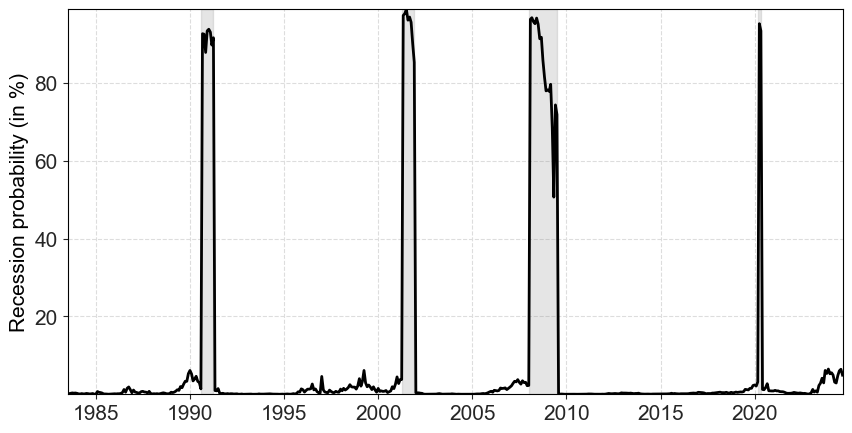

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_dynamic_data @ res_dynamic.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)
    

__Question 7__

In [57]:
"""
Log-likelihood function 
"""

def calculate_recession_probs(theta, x): 
    
    beta = theta[:-1]
    alpha = theta[-1]
    
    pi = x @ beta
    for i in range(1, len(x)):
        pi[i] += alpha * pi[i-1]
        
    prob = stats.norm.cdf(pi)
    return prob

def log_like_autoregressiv_probit(theta, y, x, individual=False): 
        
    prob = calculate_recession_probs(theta, x)
    
    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)
    

In [58]:
theta_init = [ -1.03667616, -4.831408, 0.7]
res_auto = optimize.minimize(log_like_autoregressiv_probit, theta_init,
                             args=(y_data, x_data),
                             method='L-BFGS-B',
                             #approx_grad=True,
                             #options={'eps': 1e-06,
                             #        'maxls':10},
                             options= {"gtol": 1e-6, "ftol": 1e-16, "maxfun": 30000, "maxiter": 30000, "maxls": 40},
                             bounds = ((None, None), (None, None),(0.0, 0.95)))
res_auto

C:\Users\johan\AppData\Local\Temp\ipykernel_12652\146946657.py:21: RuntimeWarning: divide by zero encountered in log
  log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
C:\Users\johan\AppData\Local\Temp\ipykernel_12652\146946657.py:21: RuntimeWarning: invalid value encountered in multiply
  log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [-3.001e-02 -4.849e+00  9.500e-01]
      nit: 10
      jac: [-1.516e+02  3.185e+00  1.805e+02]
     nfev: 148
     njev: 37
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

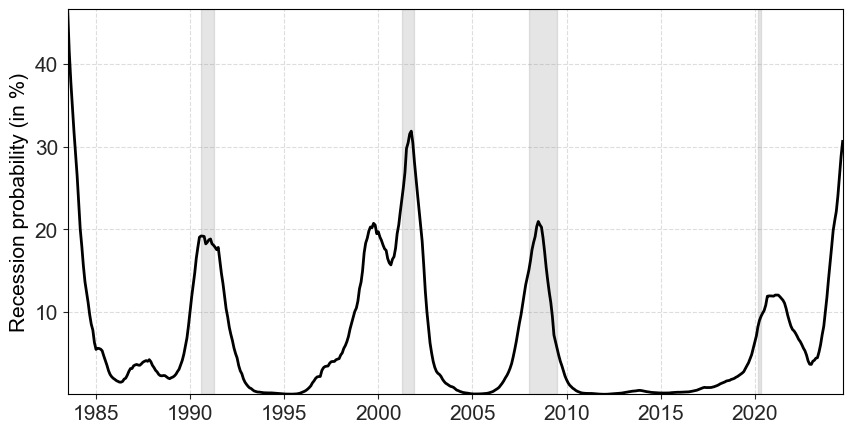

In [59]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, calculate_recession_probs(res_auto.x, x_data) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

## Problem 5: MLE and hypothesis testing [optional]

Consider the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) 

$$
f_{y}(y; \theta) = \frac{\beta^\rho}{\Gamma(\rho)} y^{\rho -1} e^{-y \beta}
$$
where $\theta = (\beta, \rho)^\top$, $\Gamma(\rho)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). 

__Question 1__

Simulate 1,000 observations assuming $\beta = 1$ and $\rho=1$ from a gamma distribution. Plot the histogram together with the true density. 

__Question 2__

Define the log-likelihood function and estimate the parameters. Note that the functions `scipy.special.gamma`, `scipy.special.gammaln`, and `scipy.special.digamma` ([digamma function](https://en.wikipedia.org/wiki/Digamma_function)) may be relevant. 

__Question 3__

The gradiant is given by 

$$
\frac{\partial q_i(y_i ;\theta)}{\partial \theta } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\\
$$

and therefore

$$
\frac{\partial q_i(y_i ;\theta)}{\partial \theta } \frac{\partial q_i(y_i ;\theta)}{\partial \theta^\top } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}^\top = \begin{bmatrix} (\rho \frac{1}{\beta} - y_i)^2 & (\rho \frac{1}{\beta} - y_i) (\ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i) \\
(\rho \frac{1}{\beta} - y_i) (\ln \beta - \frac{d \ln \Gamma (\rho)}{d \rho} + \ln y_i) & (\ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i)^2 \end{bmatrix}
$$

and the Hessian is given by 

$$
\frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top } = \begin{bmatrix} \frac{-\rho}{\beta^2}  & \frac{1}{\beta} \\
\frac{1}{\beta} & - \frac{d^2 \ln \Gamma (\rho)}{d \rho^2} \end{bmatrix}
$$

Define a function that returns 

$$
\sum_{i=1}^n\frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} = \sum_{i=1}^n \text{E} \left[ \frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} \right] = \sum_{i=1}^n \begin{bmatrix} \frac{-\rho}{\beta^2}  & \frac{1}{\beta} \\
\frac{1}{\beta} & - \frac{d \ln \Gamma (\rho)}{d \rho^2} \end{bmatrix}
$$


__Question 4__

We remember that 

$$
\hat{\theta}_{MLE} \sim^a N\left(\theta_0, -\left[ \sum_{i=1}^n \text{E} \left[ \left. \frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right]^{-1}\right)
$$

Since $\theta_0$ (in real life) is unkown, then we replace it with the obtained estimate. Calculate the standard errors of the estimator.

__Question 5__

The MLE follows a multivariate normal distribution in the limit (for simplicity let $\mathbf{V}$ denote the asymptotic variance)

$$
\hat{\theta} \sim^a N(\theta_0, \mathbf{V})
$$

If we let $\mathbf{R}$ be a $(q \times k)$ matrix and $\mathbf{r}$ be a $q \times 1$ vector where $q$ is the number of restrictions and $k$ is the number of parameters (so 2 in the model we are considering here). 

Assuming the null hypothesis 

$$
\text{H}_0 : \mathbf{R} \theta - \mathbf{r} = \mathbf{0}
$$

we will have (under the null hypothesis)

$$
\mathbf{R} \hat{\theta} - \mathbf{r} \sim^a N(\mathbf{0}, \mathbf{R}\mathbf{V}\mathbf{R}^\top)
$$

When testing a single hypothesis ($q=1$), we will have 

$$
\frac{\mathbf{R} \hat{\theta} - \mathbf{r}}{\sqrt{\mathbf{R}\mathbf{V}\mathbf{R}^\top}} \sim^a N(0, 1)
$$

If we want to test the hypothesis $\text{H}_0: \beta=1$ vs. the alternative $\text{H}_A: \beta \neq 1$ in the model considered here, we simple choose $\mathbf{R} = [0, 1]$ and $\mathbf{r} = 1$ such that 

$$
Z = \frac{\mathbf{R} \hat{\theta} - \mathbf{r}}{\sqrt{\mathbf{R}\mathbf{V}\mathbf{R}^\top}} = \frac{\hat{\beta} -  1}{\sqrt{V_{11}}} = \frac{\hat{\beta} -  1}{\sqrt{\text{Var}(\hat{\beta})}}  \sim^a N(0, 1)
$$

which is the well-known test statistic. We obtain the (two-side) $p$-value as $2 (1 - \Phi(\vert z \vert))$. 

Test the hypotheses that (one at the time) that $\beta=1$ and $\rho=1$. 


__Question 6__

We now want to test the joint hypothesis $\text{H}_0: \beta=1, \rho=1$ vs. the alternative $\text{H}_A: \beta \neq 1, \rho \neq 1$. 

To test this hypothesis, we have different possibilities:

* The likelihood ratio test
* The Wald test
* The Lagrange multiplier test

__The likelihood ratio test__

The basic idea is that we have some valid restrictions, say $\mathbf{c}(\theta) = \mathbf{r}$, then imposing it should not lead to a large reduction in the log-likelihood function. It is possible to show that the Likehood Ratio (LR) test statistic 

$$
LR = - 2 (\ln L_n^R - \ln L_n^U) \sim \chi^2 (q)
$$

follows a chi-squared distribution with degrees of freedom equal to the number of restrictions, $q$. $L_n^R$ is the restricted likelihood function and $L_n^U$ is the unrestricted likelihood function. 

__The Wald test__

If the restrictions are valid, then $\mathbf{c}(\hat{\theta}) - \mathbf{r}$ should be close to zero since the MLE is consistent. The wald test is based on $\mathbf{c}(\hat{\theta}) - \mathbf{r}$ and we will reject the hypothesis if this value is significantly different from zero. The wald test statistc can be written as 

$$
W = [\mathbf{c}\left(\hat{\theta}\right) - \mathbf{r}]^\top \left(\mathbf{C} \mathbf{V} \mathbf{C}^\top \right)^{-1} [\mathbf{c}\left(\hat{\theta}\right) - \mathbf{r}] \sim \chi^2 (q)
$$
where $\mathbf{C} = \left. \frac{\partial \mathbf{c}(\theta)}{\partial \theta^\top} \right \vert_{\theta=\hat{\theta}}$.  For linear restrictions $\mathbf{R} \theta - \mathbf{r}$, we will have

$$
W = [\mathbf{R} \hat{\theta} - \mathbf{r}]^\top \left(\mathbf{R} \mathbf{V} \mathbf{R}^\top \right)^{-1} [\mathbf{R} \hat{\theta} - \mathbf{r}] \sim \chi^2 (q)
$$

__The Lagrange multiplier test__

As the name entails, the test is related to the Lagrangian of the constrained problem 

$$
\mathcal{L}^*_n(\theta) = \mathcal{L}_n (\theta) + \lambda^\top (\mathbf{c}(\theta) - \mathbf{r}) 
$$

The solution to this constrained problem satisfies the the first order conditions 

$$
\begin{align}
\frac{\partial \mathcal{L}_n^* (\theta)}{\partial \theta}&=\frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} + \mathbf{C}^\top \lambda = \mathbf{0}\\
\frac{\partial \mathcal{L}_n^* (\theta)}{\partial \lambda}&= \mathbf{c}(\theta) - \mathbf{r} = \mathbf{0}
\end{align}
$$

The restrictions not being binding corresponds to $\lambda = \mathbf{0}$ why we may define the null hypothesis as $\text{H}_0: \lambda= \mathbf{0}$ (i.e. the lagrange multiplier being equal to zero). A more common approach is obtained by noting that evaluated at the restricted estimate, then the score should be close to zero

$$
\hat{\mathbf{g}}_R = \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R} = \hat{\mathbf{C}}^\top \lambda = \mathbf{0}
$$

Under the nulll hypothesis the Lagrange Multiplier test statistic

$$
\left[\left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R}  \right]^\top    \mathbf{V}_R \left[ \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R} \right] \sim \chi^2 (q)
$$

where $\mathbf{V}_R $ is the asymptotic variance of the restricted model. One advantage of the LM test is that we only need to estimate the model under the null hypothesis!

Implement all the three above tests. 

__Question 7__


[_Size_](https://en.wikipedia.org/wiki/Size_(statistics)) and [_power_](https://en.wikipedia.org/wiki/Power_of_a_test) are two key properties of a test.  Size is the probability of commiting a type I error, i.e. rejecting a true null hypothesis and power is the probability of rejecting a false null hypothesis. 

The distributions used above for testing hypotheses about the parameters rely on asymptotic theory, but this may be a bad approximation in small samples.

For different sample sizes, e.g. 100, 250, 500, 1000, using at least 10,000 simulated samples check how well the LR test statistic from a above follows a $\chi^2(q)$ distribution. 

__Question 8__

How often does the LR-statistic exceed the 5\% critical value for each of the sample sizes? 

__Question 9__

We want to examine the power of the LR test. To calculate the probability of rejecting the null hypothesis (we keep the one from above) given that it is false, then we need to assume some true alternative. We will assume that $\beta=1.25$. Redo the simulation and calculate how many times LR-statistic exceed the 5\% critical value for each of the sample sizes. 




### Solution 

__Question 1__

In [60]:
n = 1000
beta_true = 1.0
rho_true = 1.0
y_data = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=n)

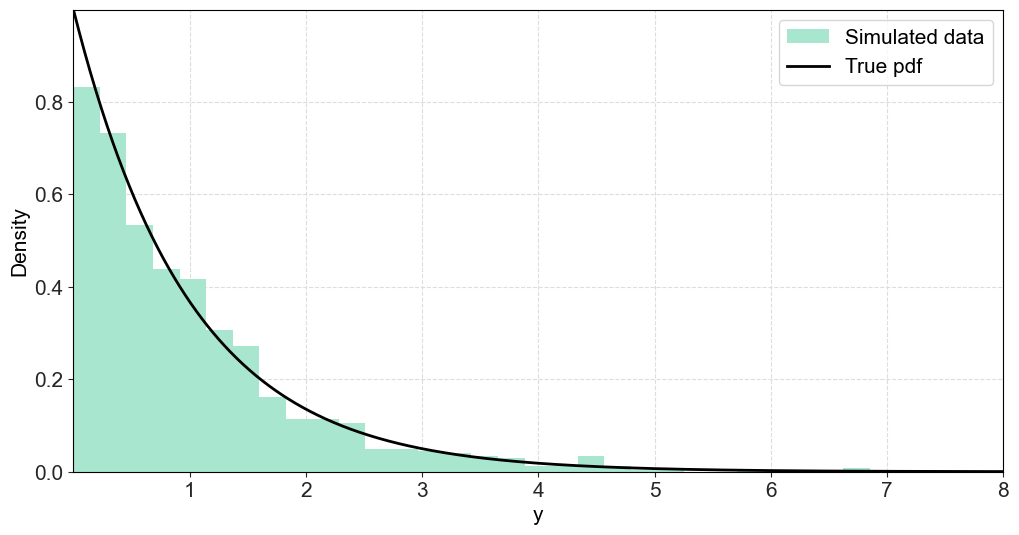

In [61]:
# density
y_vals = np.linspace(0.001, 8.0, 1000)
pdf_vals = stats.gamma.pdf(y_vals, a=rho_true, scale=1.0/beta_true)

# plotting 
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(y_data, bins=30, density=True, label="Simulated data")
ax.plot(y_vals, pdf_vals, color="black", label="True pdf")

ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend();

__Question 2__

The likelihood function can be written as 

$$
L_n(\theta) = \prod_{i=1}^n \frac{\beta^\rho}{\Gamma(\rho)} y_i^{\rho -1} e^{-y_i \beta}
$$

Taking the natural logarithm yields

$$
\mathcal{L}_{n}(\theta) = \sum_{i=1}^n q_i(y_i; \theta) = \sum_{i=1}^n \left[\rho \ln \beta - \ln \Gamma (\rho) + (\rho - 1) \ln y_i - y_i \beta \right] = n \left[\rho \ln \beta - \ln \Gamma (\rho) \right] + \sum_{i=1}^n \left[(\rho - 1) \ln y_i - y_i \beta \right]
$$



In [62]:
from scipy.special import gamma, gammaln, psi, polygamma

"""
Define log-likelihood 
"""

def log_like_gamma(theta, y,  individual=False):
    
    beta = theta[0]
    rho = theta[1]
    
    log_like = rho * np.log(beta) - gammaln(rho) + (rho - 1) * np.log(y) - y * beta
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)
    

"""
Minimize negative log-like 
"""
res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data, ))
params_mle = res.x

__Question 3__


In [63]:
def gamma_log_like_hessian(theta: np.array, y: np.array):
    
    """
    Calculates the Hessian of the log-likelihood function 
    """
    
    beta = theta[0]
    rho = theta[1]
    n = len(y)
    
    hess = np.array([[-rho / (beta**2), 1.0 / beta], [1.0 / beta, - polygamma(1, rho)]])
    
    return n * hess

__Question 4__



In [64]:
A = gamma_log_like_hessian(params_mle, y_data)
V = -np.linalg.inv(A)
np.sqrt(np.diag(V))

array([0.05069105, 0.04098061])

__Question 5__

In [65]:
"""
Testing beta=1
"""

z_beta = (params_mle[0] - 1.0) / np.sqrt(V[0,0])

p_value_beta =  2.0*(1.0 - stats.norm.cdf(np.abs(z_beta)))
p_value_beta

0.8610380473619812

In [66]:
"""
Testing rho=1
"""

z_rho = (params_mle[1] - 1.0) / np.sqrt(V[1,1])

p_value_rho =  2.0*(1.0 - stats.norm.cdf(np.abs(z_rho)))
p_value_rho

0.3618602963923978

__Question 6__



In [67]:
"""
LR test
"""

like_ratio = 2 * (log_like_gamma([1.0, 1.0], y_data) - 
                  log_like_gamma(params_mle, y_data))

p_val_lr = 1 - stats.chi2.cdf(like_ratio, 2)

print("LR: " + str(like_ratio))
print("p-value: " + str(p_val_lr))

LR: 1.636745441885978
p-value: 0.44114894316954767


In [68]:
"""
Wald test
"""
R = np.eye(2)
r = np.ones(2)
constraint = (R @ params_mle - r)
cov_inv = np.linalg.inv(R @ V @ R.T)

wald = constraint.T @ cov_inv @ constraint
p_val_wald = 1 - stats.chi2.cdf(wald, 2)

print("Wald: " + str(wald))
print("p-value: " + str(p_val_wald))

Wald: 1.6003582809097365
p-value: 0.44924847833154957


In [69]:
"""
Lagrange Multiplier test
"""

# get covariance matrix of restricted modle 
A_res = gamma_log_like_hessian([1.0, 1.0], y_data)
V_res = -np.linalg.inv(A_res)
np.sqrt(np.diag(V))

# define a function calculating the score (we could also do this numerically)
def gamma_log_like_score(theta: np.array, y: np.array, individual=False):
    
    """
    Calculates the score of the log-likelihood function 
    """
    
    beta = theta[0]
    rho = theta[1]
    n = len(y)
    
    score_beta = rho / beta - y
    score_rho = np.log(rho) -  polygamma(0, rho) + np.log(y)
    score = np.column_stack((score_beta, score_rho))
    
    if individual:
        
        return score
    
    else: 
    
        return np.sum(score, axis=0)
    
# calculate score
score_restricted = gamma_log_like_score([1.0, 1.0], y_data, individual=False)

# LM stat
lm = score_restricted.T @ V_res @ score_restricted

p_val_lm = 1 - stats.chi2.cdf(lm, 2)

print("LM: " + str(lm))
print("p-value: " + str(p_val_lm))

LM: 1.6012437498381553
p-value: 0.4490496245701535


In [70]:
gamma_log_like_score([1.0, 1.0], y_data, individual=True)

array([[ 0.95092043, -2.43709685],
       [ 0.56703766, -0.25988886],
       [-0.08741623,  0.66102012],
       ...,
       [-0.48817579,  0.97476673],
       [ 0.35045926,  0.14572595],
       [ 0.95117319, -2.4422601 ]])

In [71]:
# the numerical derivative will have a different sign since we have defined the negative log-likelihood
approx_fprime(np.array([1.0, 1.0]), log_like_gamma, args=(y_data, True))

array([[-0.95092043,  2.43709686],
       [-0.56703765,  0.25988888],
       [ 0.08741623, -0.6610201 ],
       ...,
       [ 0.48817579, -0.97476672],
       [-0.35045926, -0.14572594],
       [-0.95117318,  2.44226011]])

__Question 7__

First, we simulate all the data that we need to use.

In [72]:
n = 500
num_sim = 10000
beta_true = 1.0
rho_true = 1.0
y_data_all = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=(num_sim, n))

In [73]:
sample_sizes = [25, 50, 100, 500]
output_lr = np.empty((num_sim, len(sample_sizes)))

for j, sample_size in enumerate(sample_sizes):
    for i in range(num_sim):
        
        # select data
        y_data = y_data_all[i, :sample_size]

        # estimate 
        res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data,),
                                bounds=((0.001, None), (0.001, None)))
        # calculate LR statistics 
        output_lr[i, j] = 2 * (log_like_gamma([1.0, 1.0], y_data) - log_like_gamma(res.x, y_data))


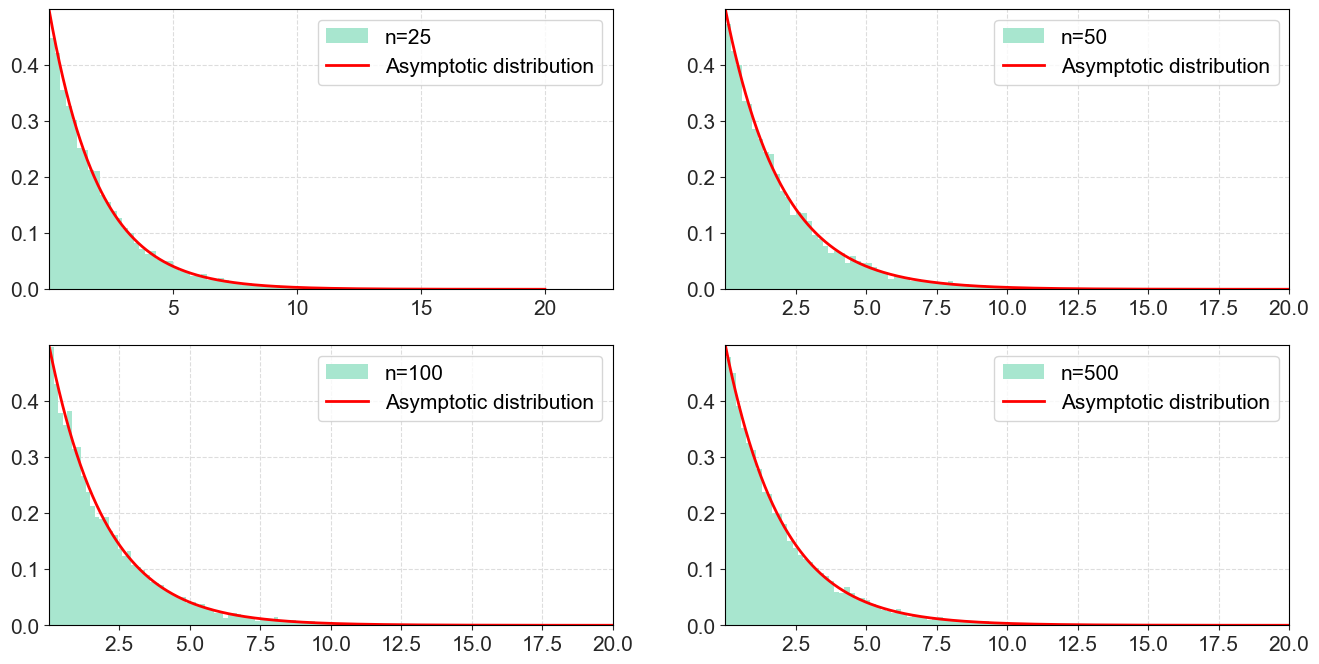

In [74]:
"""
Histogram and chi^2(2)
"""
x_values = np.linspace(0.001, 20, 1000)
chi_pdf_values = stats.chi2.pdf(x_values, 2)

fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax = ax.flatten()
for i in range(len(sample_sizes)):
    ax[i].hist(output_lr[:, i], bins=100, density=True, label="n={}".format(sample_sizes[i]), alpha=1.0); 
    ax[i].plot(x_values, chi_pdf_values, color="red", label="Asymptotic distribution")
    ax[i].legend();


__Question 8__

The test seems to be well sized in the sense that the proportion of rejection the null hypothesis is close to the significance level. 

In [75]:
np.sum(output_lr>stats.chi2.ppf(0.95, 2), axis=0) / num_sim 

array([0.0549, 0.0532, 0.0525, 0.0498])

__Questio 9__

Naturally, the power is increasing with the sample size!

In [76]:
n = 500
num_sim = 10000
beta_true = 1.25
rho_true = 1.0
y_data_all = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=(num_sim, n))

In [77]:
sample_sizes = [25, 50, 100, 500]
output_power_lr = np.empty((num_sim, len(sample_sizes)))

for j, sample_size in enumerate(sample_sizes):
    for i in range(num_sim):
        
        # select data
        y_data = y_data_all[i, :sample_size]

        # estimate 
        res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data,),
                                bounds=((0.001, None), (0.001, None)))
        # calculate LR statistics 
        output_power_lr[i, j] = 2 * (log_like_gamma([1.0, 1.0], y_data) - log_like_gamma(res.x, y_data))


In [78]:
np.sum(output_power_lr>stats.chi2.ppf(0.95, 2), axis=0) / num_sim 

array([0.1484, 0.2486, 0.4753, 0.9977])

### Statsmodels implementation

In [79]:
from statsmodels.base.model import GenericLikelihoodModel

class GammaLogLModel(GenericLikelihoodModel):
    
    nparams = 2
    
    def loglike(self, params):
        
        endog = self.endog
        
        beta = params[0]
        rho = params[1]
        
        return stats.gamma.logpdf(endog, rho, scale = 1.0 / beta).sum()


res = GammaLogLModel(y_data).fit(start_params=[1.0, 1.0])

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.743306
         Iterations: 31
         Function evaluations: 59
                            GammaLogLModel Results                            
Dep. Variable:                      y   Log-Likelihood:                -371.65
Model:                 GammaLogLModel   AIC:                             751.3
Method:            Maximum Likelihood   BIC:                             768.2
Date:                Sun, 06 Oct 2024                                         
Time:                        19:11:27                                         
No. Observations:                 500                                         
Df Residuals:                     498                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

__Question 5__

In [80]:
res.t_test('par0=1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.2434      0.089      2.725      0.006       1.068       1.418

In [81]:
res.t_test('par1=1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9623      0.053     -0.705      0.481       0.858       1.067

## Problem 6: Shrinkage estimators

Assume that $\mathbf{X} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ is multivariate normal. 

The [Mean-Squared-Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) of the sample mean can be written as 

$$
\text{MSE} \equiv \text{E}[\| \bar{\mathbf{X}} - \boldsymbol{\mu} \|^2] = \text{E}\left[\| \bar{\mathbf{X}} - \text{E}[\bar{\mathbf{X}}] \|^2 \right] + \left \|\text{E}[\bar{\mathbf{X}}] - \boldsymbol{\mu}\right \|^2 = \text{Var}[\bar{\mathbf{X}}] + \text{Bias}[\bar{\mathbf{X}}, \boldsymbol{\mu}]^2
$$

where $\| \cdot \|$ denotes the [norm](https://en.wikipedia.org/wiki/Norm_(mathematics)). Basically, this tells us that we can look at an estimator in relation to its bias and inefficiency (variance). 

In this exercise, we will see if we can find another estimator that performs better than the sample mean (in mean-square sense) 

$$
\bar{\mathbf{X}} = \frac{1}{n} \sum_{i=1}^n \mathbf{X}_i
$$

__Question 1__

Assume that 

$$
\boldsymbol{\mu} = \begin{bmatrix} 0.0 \\ 0.0 \\ 0.1 \\ -0.1 \\ 0.2 \end{bmatrix}
$$

and for $\theta \in (0, 1)$

$$
\boldsymbol{\Sigma} = \begin{bmatrix}
1 & \theta & \dots & \theta \\
\theta & 1 & \ddots & \vdots \\
\theta & \theta & \ddots & \theta \\
\theta & \theta & \dots & 1 \\
\end{bmatrix}
$$

We can think of $\theta$ as representing the overall correlation among the random variables. 

For $\theta \in [0.0, 0.1, 0.2, ... , 0.9, 0.99]$ simulate 100 observations 10,000 times. Calculate the simulated value of the MSE for each different value of $\theta$ (remember that we know the true value of $\boldsymbol{\mu}$). Plot a stacked bar plot with MSE divided into variance and bias. 


__Question 2__

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646) presents the [_James-Stein shrinkage estimator_](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of the expected value

$$
\hat{\boldsymbol{\mu}} = (1-\alpha) \bar{\mathbf{X}} + \alpha \mathbf{b}
$$
where $\mathbf{b}$ is a constant vector. The optimal $\alpha$ is given by 

$$
\alpha = \frac{1}{n} \frac{m \bar{\lambda} - 2 \lambda_1}{(\bar{\mathbf{X}} -  \mathbf{b})^\top (\bar{\mathbf{X}} -  \mathbf{b})}
$$
where  $m$ is the number of variables,  $\bar{\lambda}$ and $\lambda_1$ are respectively the average value and largest value of the eigenvalues of $\boldsymbol{\Sigma}$. 

We choose to shrink towards the "grand-mean"

$$
\frac{\mathbf{1}^\top \bar{X}}{m} \mathbf{1}
$$

where $\mathbf{1}$ is a m-dimensional vector of ones. 

Implement the estimator and perform the same calculations as in the previous question. Can the shrinkage estimator perform better than the sample mean?


### Solution 

__Question 1__

In [82]:
num_var = 5
num_sim = 100000
num_obs = 100

theta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
mu_values = np.array([0.0, 0.0, 0.1, -0.1, 0.2])

# standard normal random variables
random_draws = np.random.normal(size=(num_var, num_obs, num_sim))

all_mse = list()
all_bias = list() 
all_var = list()
for theta in theta_values: 
    
    # construct corr / covariance matrix
    corr = np.tile(theta, (num_var, num_var))
    np.fill_diagonal(corr, 1.0)
    
    # Use cholesky decomposition to normal random variables
    transformed_random_draws = mu_values[:, None, None] + np.einsum('ij,jlk->ilk',
                                                                    np.linalg.cholesky(corr), random_draws)
    
    # calculate average of all sample means
    expected_sample_mean = np.mean(np.mean(transformed_random_draws, axis=1), axis=1)
    
    # calculate the variance
    var =  np.mean(np.linalg.norm(np.mean(transformed_random_draws, axis=1) - 
                          expected_sample_mean[:, None], axis=0)**2)
    
    # calculate the bias squared
    bias = np.linalg.norm(expected_sample_mean - mu_values)**2
    
    # calculate the total MSE (should be equal to var + bias)
    mse = np.mean(np.linalg.norm(np.mean(transformed_random_draws, axis=1) - mu_values[:, None], axis=0)**2)
    # or just use np.trace(corr) / num_obs <- theoretical correct value
    
    all_mse.append(mse)
    all_bias.append(bias)
    all_var.append(var)
    
    

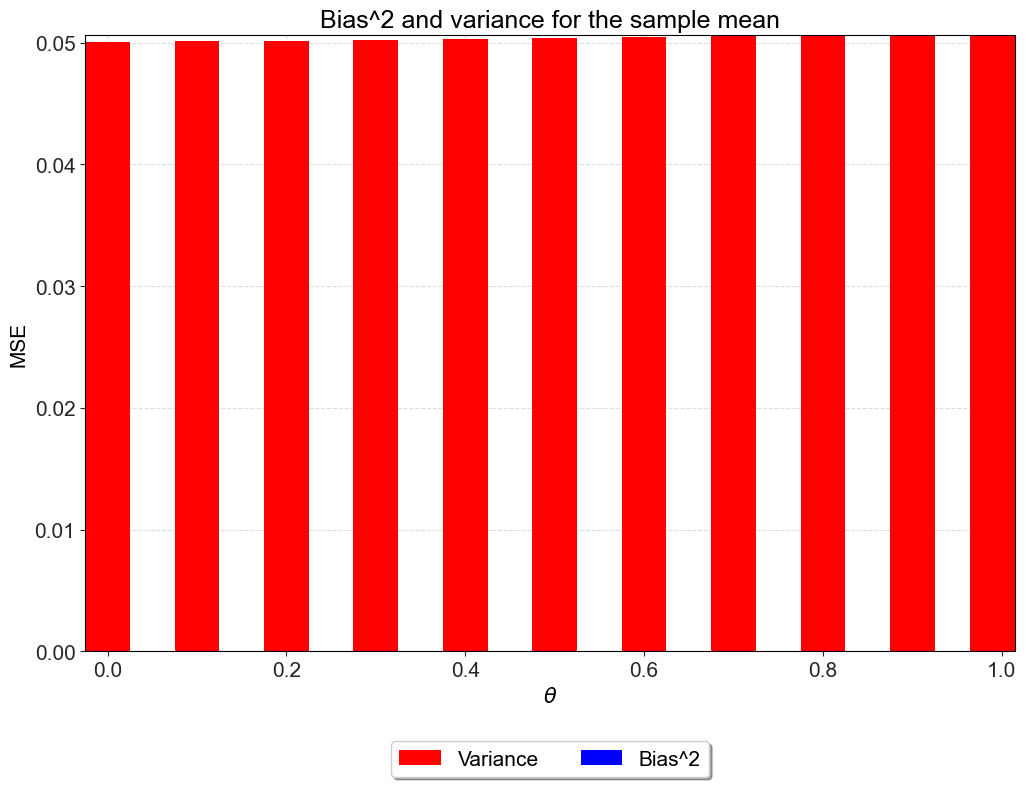

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(theta_values, all_var, width=0.05, label="Variance", color="red");
ax.bar(theta_values, all_bias, width=0.05, bottom=all_var, label="Bias^2", color="blue");
ax.set_ylabel('MSE')
ax.set_xlabel('$\\theta$')
ax.set_title("Bias^2 and variance for the sample mean")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

The sample mean is an unbiased estimator so the only problem is coming from the variance. 

__Question 2__


We see that with limited correlation between the variables, then the shrinkage estimator lowers the total MSE. 

In [84]:
all_mse_shrink = list()
all_bias_shrink = list() 
all_var_shrink = list()
for theta in theta_values: 
    
    # construct corr / covariance matrix
    corr = np.tile(theta, (num_var, num_var))
    np.fill_diagonal(corr, 1.0)
    
    # Use cholesky decomposition to normal random variables
    transformed_random_draws = mu_values[:, None, None] + np.einsum('ij,jlk->ilk',
                                                                    np.linalg.cholesky(corr), random_draws)
    
    # average and maximum eigenvalue
    eig_vals = np.linalg.eigvals(corr)
    max_eig = max(eig_vals)
    avg_eig = np.mean(eig_vals)

    # get grand mean
    x_bar = np.mean(transformed_random_draws, axis=1)
    b = np.mean(x_bar, axis=0)
    b = np.tile(b, (num_var, 1))
    
    # calculate optimal alpha
    diff = x_bar - b
    denominator = np.einsum('ij,ij->j', diff, diff)

    alpha = (1.0 / num_obs) * (num_var * avg_eig - 2 * max_eig)  / denominator
    alpha = np.clip(alpha, 0, 1)
    alpha = np.tile(alpha, (num_var, 1))
    
    # shrinkage estimator
    mu_est = x_bar * (1 - alpha) + b * alpha

    # calculate average of all mean estimates
    expected_sample_mean = np.mean(mu_est, axis=1)
    
    # calculate the variance
    var =  np.mean(np.linalg.norm(mu_est - expected_sample_mean[:, None], axis=0)**2)
    
    # calculate bias squared
    bias = np.linalg.norm(expected_sample_mean - mu_values)**2
    
    # calculate the total MSE (should be equal to var + bias)
    mse = np.mean(np.linalg.norm(mu_est - mu_values[:, None], axis=0)**2)
    
    all_mse_shrink.append(mse)
    all_bias_shrink.append(bias)
    all_var_shrink.append(var)
    

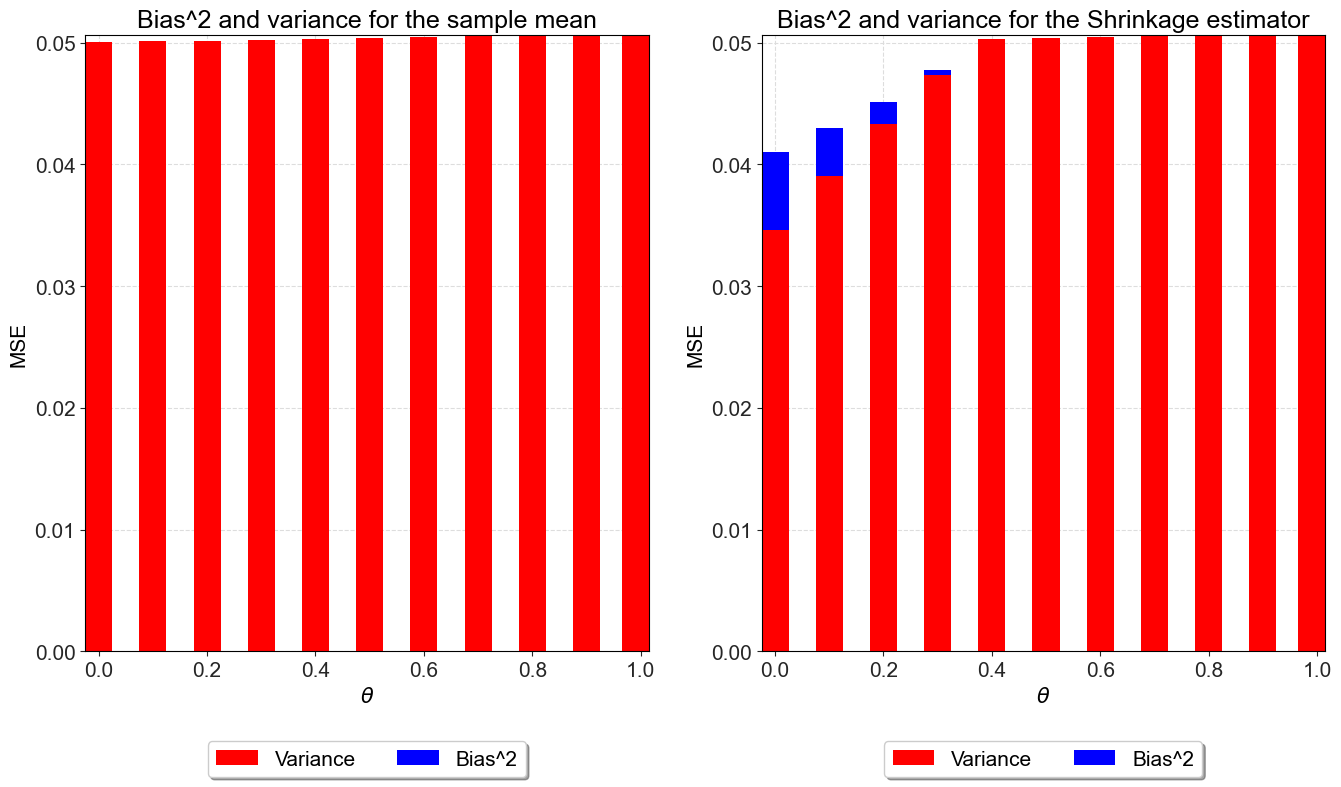

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))


ax[0].bar(theta_values, all_var, width=0.05, label="Variance", color="red");
ax[0].bar(theta_values, all_bias, width=0.05, bottom=all_var, label="Bias^2", color="blue");
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('$\\theta$')
ax[0].set_title("Bias^2 and variance for the sample mean")
ax[0].legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

ax[1].bar(theta_values, all_var_shrink, width=0.05, label="Variance", color="red");
ax[1].bar(theta_values, all_bias_shrink, width=0.05, bottom=all_var_shrink, label="Bias^2", color="blue");
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$\\theta$')
ax[1].set_title("Bias^2 and variance for the Shrinkage estimator")
ax[1].legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

# References


## Articles



## Books

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646)